In [1]:
#import sys
#sys.path.insert(0, '/Users/timkrausz/Documents/GitHub/Maze-photometry-analyses/')

In [1]:
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import scipy.io
import statsmodels.api as sm
from sklearn.linear_model import Lasso
#from phot_funcs import *
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from TriFuncs import airPLS, WhittakerSmooth, get_zdFF

In [2]:
def transform_scatter(points, image, rotate_center=(0,0)):
    fig, ax = plt.subplots(figsize=(12,10))
    plt.subplots_adjust(left=0.25, bottom=0.25)

    ax.imshow(image, extent=[0, 640, 0, 480])
    scatter = ax.scatter(points[:,0], points[:,1],marker='H',color='steelblue',alpha=0.5,s=1000)

    axcolor = 'lightgoldenrodyellow'
    ax_scale = plt.axes([0.25, 0.1, 0.65, 0.03], facecolor=axcolor)
    ax_translate_x = plt.axes([0.25, 0.05, 0.65, 0.03], facecolor=axcolor)
    ax_translate_y = plt.axes([0.25, 0.0, 0.65, 0.03], facecolor=axcolor)
    ax_rotate = plt.axes([0.25, 0.15, 0.65, 0.03], facecolor=axcolor)

    s_scale = Slider(ax_scale, 'Scale', 0.1, 1.5, valinit=1.0)
    s_translate_x = Slider(ax_translate_x, 'Translate X', -200, 200, valinit=0)
    s_translate_y = Slider(ax_translate_y, 'Translate Y', -200, 200, valinit=0)
    s_rotate = Slider(ax_rotate, 'Rotate', -30, 30, valinit=0)

    def update(val):
        #clear_output()
        scale = s_scale.val
        translate_x = s_translate_x.val
        translate_y = s_translate_y.val
        rotate_deg = s_rotate.val

        # Scale
        scale_matrix = np.array([[scale, 0, 0],
                                 [0, scale, 0],
                                 [0, 0, 1]])

        # Translate
        translate_matrix = np.array([[1, 0, translate_x],
                                     [0, 1, translate_y],
                                     [0, 0, 1]])

        # Rotate
        rotate_rad = np.deg2rad(rotate_deg)
        rotate_matrix = np.array([[np.cos(rotate_rad), -np.sin(rotate_rad), 0],
                                  [np.sin(rotate_rad), np.cos(rotate_rad), 0],
                                  [0, 0, 1]])

        # Rotate around specified center
        center_matrix = np.array([[1, 0, rotate_center[0]],
                                  [0, 1, rotate_center[1]],
                                  [0, 0, 1]])
        center_translate_matrix = np.array([[1, 0, -rotate_center[0]],
                                            [0, 1, -rotate_center[1]],
                                            [0, 0, 1]])
        rotate_around_center_matrix = center_translate_matrix.dot(rotate_matrix).dot(center_matrix)

        # Transform points
        transform_matrix = rotate_around_center_matrix.dot(scale_matrix).dot(translate_matrix)
        transformed_points = transform_matrix.dot(points.T).T

        # Update scatter plot
        scatter.set_offsets(transformed_points[:,:2])
        #scatter.set_color(transformed_points[:,2])

        fig.canvas.draw_idle()
        global new_coords
        new_coords = transformed_points[:,:2]
        global transformParams
        print("rotate degree, scale, x tran, y tran = ",[rotate_deg,scale,translate_x,translate_y])
        transformParams = [rotate_deg,scale,translate_x,translate_y]
        #print(transformed_points)
    s_scale.on_changed(update)
    s_translate_x.on_changed(update)
    s_translate_y.on_changed(update)
    s_rotate.on_changed(update)

    plt.show()
    
def assign_to_hexagon(x, y, centroids):
    """
    Assigns each point in the given x-y coordinate vector to the closest hexagonal region of interest
    with the specified centroids.
    Parameters:
        x (np.ndarray): A 1D numpy array of x-coordinates.
        y (np.ndarray): A 1D numpy array of y-coordinates.
        centroids (np.ndarray): A 2D numpy array of hexagonal region centroids, where each row contains
            the x and y coordinates of the centroid of a region of interest.
    Returns:
        A 1D numpy array of integers, where each element is the index of the closest centroid in the
        centroids array.
    """
    # Calculate the Euclidean distance between each point and each centroid
    x_np = np.array(x) if not isinstance(x, np.ndarray) else x
    y_np = np.array(y) if not isinstance(y, np.ndarray) else y
    distances = np.sqrt((x_np[:, np.newaxis] - centroids[:, 0])**2 + (y_np[:, np.newaxis] - centroids[:, 1])**2)
    # Find the index of the closest centroid for each point
    closest_centroid_indices = np.argmin(distances, axis=1) +1
    
    return closest_centroid_indices
    

#compute the centroids of the initial hexagons
hexlist = [2,47,46,45,44,43,3,\
49,42,41,40,39,48,\
38,37,36,35,34,33,\
32,31,30,29,28,\
27,26,25,24,23,\
22,21,20,19,\
18,17,16,15,\
14,13,12,\
11,10,9,\
8,7,\
6,5,\
4,\
1]
#hexlist = np.subtract(hexlist,1) #convert to index-based states
coords = []
cols = [7,6,6,5,5,4,4,3,3,2,2,1,1]
maxrows = 13
r = 0
x = 1
y = 1
startr = 1
while r < maxrows:
    maxcols = cols[r]
    c = 0
    if r%2!=0:
        startr+=1
    x=startr
    while c < maxcols:
        coords.append([x,y])
        x += 2
        c += 1
    if r%2!=0:
        y += 2
    else:
        y+=1
    r += 1
cents = {h: c for h,c in zip(hexlist,coords)}


# define the centroids of the hexagons
centroids = np.zeros((49,2))
for h in list(cents.keys()):
    centroids[h-1] = cents[h]

centroids[:,0] = centroids[:,0]/centroids[:,0].max()*450 +80
centroids[:,1] = centroids[:,1]/centroids[:,1].max()*410

In [3]:
noPhot = False

%matplotlib qt
animal = "IM-"+input('rat: ') #i.e. IM-1006
#filepath = "/Volumes/Tim/Photometry/"+ animal + '/'
filepath = "/Volumes/Tim-1/Photometry/"+ animal + '/'
date = input('date: ') #format: mmddyyyy
ses_type = input('Block change = prob or barrier? ')
analcolor = 'green'# input('color of dLight?')
filecount = '0'# input('file suffix number: ')
# std used for gaussian smoothing of position data. In Weill building,
# recommend using sigma = 2
gausSigma = 0.1
usePosSmoothing = False

if noPhot:
    rec_folder = input("recording folder name? (yyyy-mm-dd_hh-mm-ss)")

# # Script to create and save sampleframe and triframe to directory


import numpy as np
import pandas as pd
import ipywidgets as widgets
import ipympl
import csv
import matplotlib.pyplot as plt
import scipy.io
from sklearn.linear_model import Lasso
from scipy.signal import lfilter,resample,decimate,correlate
from matplotlib.lines import Line2D
import process_ephys_visitData
from TriFuncs import * #custom functions for following analysis
#get_ipython().run_line_magic('matplotlib', '')

#get variables from main script
from __main__ import *

#set path to access previously stored .mat files, etc. use scipy.io.loadmat()
datepath = filepath + date + '/'
savepath = datepath
phot_dlc = input('photometry DLC? y/n')

from photProcessingFuncs import *

ephysSR = 1500 #sampling rate of ephys system for vis
Fs = 250
VizGetter = process_ephys_visitData.EphysVisitGetter(animal,date,rec_folder,ephysSR)
VizGetter.prepData()
n_seconds = VizGetter.getSeshDurationInS()
# fill in nansig with nan vector of length Fs*n_seconds
nansig = np.full(int(Fs*(n_seconds+10)),np.nan)
#need to get visits from ephys data. should be 
visits = VizGetter.get_visit_times()
visits = visits[1:] - visits[0]
visits = np.unique(visits)
print(visits.astype(int))

shiftVisByN = int(input("adjust visits by removing n indices from start?"+\
    " (input n; if 1 is first index, input 1)"))
visits = visits[shiftVisByN:]

#get sample numbers of visit indices
visits = np.divide(visits,ephysSR/Fs)
visits = visits.astype(int)


#import arduino behavioral data and their timestamps
a = open(datepath+'arduinoraw'+str(filecount)+'.txt','r')
ardtext= a.read().splitlines()
a.close

with open(datepath+'ArduinoStamps'+str(filecount)+'.csv','r') as at:
    reader = csv.reader(at)
    ardtimes = list(reader)
ardtimes = [float(val) for sublist in ardtimes for val in sublist]

photstart = ardtimes[1] #time when pulse was sent to R series. 0 index for sig data
ardtimes = np.subtract(ardtimes,photstart) #make photometry start time zero

#convert ardtimes to sample number to match photometry data. 
#Target rate = 250/sec from 10 KHz initial sample rate (same as photometry)
ardstamps = np.round(ardtimes*(Fs/1000)).astype(int)

visits = visits[1:] - visits[0]
vis4pos = visits
x,y,vel,framestamps,acc,dlc_pos = align_pos_to_visits(Fs,vis4pos,datepath,
    phot_dlc=phot_dlc,filecount=filecount,gaus_smooth=usePosSmoothing,sigma=gausSigma,cutoff=0.4)

plt.figure()
plt.plot(framestamps)
plt.title("camera frame stamps in photometry sample time")


#Make dataframe with all data organized by sample number
visits = np.unique(visits)

#This is where the problem is... not the right length.
a = np.tile(0,(len(nansig),22))
data = np.full_like(a, np.nan, dtype=np.double) #make a sample number x variable number array of nans
#fill in nans with behavioral data. columns = x,y,ach,dlight,port,rwd,roi
#give signal columns dff values
data[:,2] = nansig 
data[:,3] = 0
data[:,16] = nansig
data[:,17] = 0
data[:,11] = nansig
block = 1
tris = 0
trial = 1
data[0,15] = 0
pA = np.nan
pB = np.nan
pC = np.nan
#get sample number of current trial to align phot data to port entries
#data = list(data)
#fill in reward and port info. Ports are coded by 1:A,2:B,3:C
for i in range(len(ardtext)):
    try:
        vsamp = visits[tris]
    except:
        print('end of trials reached')
    new = False
    if 'A Harvested' in ardtext[i] or "delivered at port A" in ardtext[i]:
        data[vsamp,4] = 0
        data[vsamp,5] = 1
        data[vsamp+1,15] = 0
        trial += 1
        tris += 1
    elif 'B Harvested' in ardtext[i] or "delivered at port B" in ardtext[i]:
        data[vsamp,4] = 1
        data[vsamp,5] = 1
        data[vsamp+1,15] = 1
        trial += 1
        tris += 1
    elif 'C Harvested' in ardtext[i] or "delivered at port C" in ardtext[i]:
        data[vsamp,4] = 2
        data[vsamp,5] = 1
        data[vsamp+1,15] = 2
        trial += 1
        tris += 1
    elif 'o Reward port A' in ardtext[i]:
        data[vsamp,4] = 0
        data[vsamp,5] = 0
        data[vsamp+1,15] = 0
        trial += 1
        tris += 1
    elif 'o Reward port B' in ardtext[i]:
        data[vsamp,4] = 1
        data[vsamp,5] = 0
        data[vsamp+1,15] = 1
        trial += 1
        tris += 1
    elif 'o Reward port C' in ardtext[i]:
        data[vsamp,4] = 2
        data[vsamp,5] = 0
        data[vsamp+1,15] = 2
        trial += 1
        tris += 1
    elif 'Lick at port A' in ardtext[i] or "beam break at port A" in ardtext[i]:
        data[ardstamps[i],18] = 1
    elif 'Lick at port B' in ardtext[i] or "beam break at port B" in ardtext[i]:
        data[ardstamps[i],19] = 1
    elif 'Lick at port C' in ardtext[i] or "beam break at port C" in ardtext[i]:
        data[ardstamps[i],20] = 1
    elif "Block" in ardtext[i]:
        block = int(ardtext[i][-1]) + 1
        new = True
        pA = ardtext[i+1][-2:]
        pB = ardtext[i+2][-2:]
        pC = ardtext[i+3][-2:]
    data[ardstamps[i],6] = block #block number
    data[ardstamps[i],7] = pA
    data[ardstamps[i],8] = pB
    data[ardstamps[i],9] = pC
    if new == True:
        trial = 0 #reset trials within block
    data[ardstamps[i],14] = trial
    data[ardstamps[i],21]

data[framestamps[:len(x)],0] = x
data[framestamps[:len(x)],1] = y
data[framestamps[:len(x)],10] = framestamps[:len(x)]
data[framestamps[:len(x)],12] = vel
data[framestamps[:len(x)],13] = acc

#if only dLight
sampledata = pd.DataFrame(data,columns = ['x','y','green','red','port','rwd','block','pA','pB','pC','frame','ref',\
    'vel','acc','tri','fromP','470','565','beamA','beamB','beamC','tot_tri'])

sampledata = sampledata.drop(['red','565'],axis=1)
visinds = sampledata.loc[sampledata.port.notnull()].index.values
tritimes = np.diff(visinds)/Fs
tts = plt.figure()
plt.title('Distribution of trial times')
plt.hist(tritimes,bins=100)
plt.ylabel('# of trials')
plt.xlabel('trial time (s)')
tts.savefig(datepath+'trial_time_dist.pdf')




#sampledata.loc[(sampledata.x.diff()==0)|(sampledata.y.diff()==0),['x','y']]=np.nan
#sampledata.loc[(sampledata.x>550)|(sampledata.x<100),['x','y']]=np.nan

plt.figure()
plt.plot(sampledata.loc[(sampledata.x.notnull()),"x"].values[:visinds[-1]],
            sampledata.loc[(sampledata.x.notnull()),"y"].values[:visinds[-1]])
plt.plot(x,y,color='darkorange')

plt.figure()
plt.scatter(sampledata.loc[visinds[20]:visinds[21],'x'],sampledata.loc[visinds[20]:visinds[21],'y'])
plt.scatter(sampledata.loc[visinds[21]:visinds[22],'x'],sampledata.loc[visinds[21]:visinds[22],'y'])


#z-score and save signal as zscore
zscored = np.divide(np.subtract(sampledata.green,sampledata.green.mean()),sampledata.green.std())
sampledata['green_z_scored'] = zscored
#zscored = np.divide(np.subtract(sampledata.red,sampledata.red.mean()),sampledata.red.std())
#sampledata['red_z_scored'] = zscored

#add column indicating recording location
sampledata['fiberloc'] = np.nan

#create list of repeating session type string for addition to data frame
sampledata['session_type']=ses_type

#note which date and animal data comes from
anlist = np.full_like(data[:,15],0)
anlist = [animal for i in anlist]
sampledata['rat']=anlist
datelist = np.full_like(data[:,15],0)
datelist = [date for i in datelist]
sampledata['date']=datelist

#sampledata['short_tri']=short
sampledata['frame']=sampledata.frame.fillna(method='ffill')
sampledata['pA']=sampledata.pA.fillna(method='ffill')
sampledata['pA']=sampledata.pA.fillna(method='bfill')
sampledata['pB']=sampledata.pB.fillna(method='ffill')
sampledata['pB']=sampledata.pB.fillna(method='bfill')
sampledata['pC']=sampledata.pC.fillna(method='ffill')
sampledata['pC']=sampledata.pC.fillna(method='bfill')
sampledata['block']=sampledata.block.fillna(method='ffill')
sampledata['tri']=sampledata.tri.fillna(method='ffill')
sampledata['fromP']=sampledata.fromP.fillna(method='ffill')

ps = ['pA','pB','pC']
tridat = sampledata.loc[sampledata.port.isnull()==False]
tridat = tridat.reset_index()
ports=tridat.port.values
nextp=ports[1:]
nextprob = []
for n in range(len(nextp)):
    nextprob.append(tridat.loc[n,ps[int(nextp[int(n)])]])
npo = pd.DataFrame()
npo['nextprob'] = nextprob
npo['nextport'] = nextp
#add back to sampledata
addto = sampledata.loc[sampledata.port.isnull()==False].index[:-1]
npo = npo.set_index(addto)
npo = npo.reindex(np.arange(sampledata.index[0],sampledata.index[-1]+1),fill_value=np.nan)
sampledata['nextprob'] = npo.nextprob.fillna(method='ffill')
sampledata['nextp'] = npo.nextport.fillna(method='ffill')
tridat['nextp'] = np.concatenate([nextp,[10]])
tridat['lrchoice'] = make_lr(tridat.port.values)

xytups = [tuple(t) for t in sampledata[['x','y']].dropna().values.tolist()] #create list of point tuples

#also want these in sampledata. Should do block by block if ses_type == 'barrier'
if ses_type=='prob':
    tridat['lenAC'] = input('length of A-C?')
    tridat['lenBC'] = input('length of B-C?')
    tridat['lenAB'] = input('length of A-B?')
else:
    tridat['lenAC']=0
    tridat['lenBC']=0
    tridat['lenAB']=0
    for b in tridat.block.unique():
        tridat.loc[tridat.block==b,'lenAC'] = input('min length of A-C in block '+str(b)+'?')
        tridat.loc[tridat.block==b,'lenBC'] = input('min length of B-C in block '+str(b)+'?')
        tridat.loc[tridat.block==b,'lenAB'] = input('min length of A-B in block '+str(b)+'?')
plengths = pd.DataFrame()
plengths['lenAC'] = tridat.lenAC
plengths['lenAB'] = tridat.lenAB
plengths['lenBC'] = tridat.lenBC
addto = visinds
plengths = plengths.set_index(addto)
plengths = plengths.reindex(np.arange(sampledata.index[0],sampledata.index[-1]+1),fill_value=np.nan)

sampledata['lenAC'] = plengths['lenAC'].fillna(method='bfill')
sampledata['lenBC'] = plengths['lenBC'].fillna(method='bfill')
sampledata['lenAB'] = plengths['lenAB'].fillna(method='bfill')

#compute a simple reward rate estimate (rewards per minute)
rr = simple_rr(sampledata)
sampledata['simple_rr'] = rr.fillna(0)

addto = visinds
pchosen=[]
for i in visinds:
    if sampledata.loc[i,'port'] == 0:
        pchosen.append(sampledata.loc[i,'pA'])
    elif sampledata.loc[i,'port'] == 1:
        pchosen.append(sampledata.loc[i,'pB'])
    elif sampledata.loc[i,'port'] == 2:
        pchosen.append(sampledata.loc[i,'pC'])
pchosen = pd.DataFrame(pchosen)
pchosen = pchosen.set_index(addto)
pchosen = pchosen.reindex(np.arange(sampledata.index[0],sampledata.index[-1]+1),fill_value=np.nan)
sampledata['pchosen'] = pchosen.fillna(method='bfill')

#add column for the distance to the next (chosen) port
addto = visinds[1:]
dtop=[]
for i in addto:
    if sampledata.loc[i,'port'] == 0 and sampledata.loc[i,'fromP']==1:
        dtop.append(sampledata.loc[i,'lenAB'])
    elif sampledata.loc[i,'port'] == 1 and sampledata.loc[i,'fromP']==0:
        dtop.append(sampledata.loc[i,'lenAB'])
    elif sampledata.loc[i,'port'] == 0 and sampledata.loc[i,'fromP'] == 2:
        dtop.append(sampledata.loc[i,'lenAC'])
    elif sampledata.loc[i,'port'] == 2 and sampledata.loc[i,'fromP'] == 0:
        dtop.append(sampledata.loc[i,'lenAC'])
    elif sampledata.loc[i,'port'] == 1 and sampledata.loc[i,'fromP'] == 2:
        dtop.append(sampledata.loc[i,'lenBC'])
    elif sampledata.loc[i,'port'] == 2 and sampledata.loc[i,'fromP'] == 1:
        dtop.append(sampledata.loc[i,'lenBC'])
dtop = pd.DataFrame(dtop)
dtop = dtop.set_index(addto)
dtop = dtop.reindex(np.arange(sampledata.index[0],sampledata.index[-1]+1),fill_value=np.nan)
sampledata['dtop'] = dtop.fillna(method='bfill')

#fill beam nans with 0s
sampledata['beamA'] = sampledata.beamA.fillna(0)
sampledata['beamB'] = sampledata.beamB.fillna(0)
sampledata['beamC'] = sampledata.beamC.fillna(0)




sampledata['nom_rwd_a'] = sampledata.pA
sampledata['nom_rwd_b'] = sampledata.pB
sampledata['nom_rwd_c'] = sampledata.pC

sampledata = reduce_mem_usage(sampledata)
#save dataframes
sampledata.to_csv(savepath+'sampleframe.csv')
tridat.to_csv(savepath+'triframe.csv')



visits = visits[1:] - visits[0]
vis4pos = visits
x,y,vel,framestamps,acc,dlc_pos = align_pos_to_visits(Fs,vis4pos,datepath,
    phot_dlc=phot_dlc,filecount=filecount,gaus_smooth=usePosSmoothing,sigma=gausSigma,cutoff=0.4)

plt.figure()
plt.plot(framestamps)
plt.title("camera frame stamps in photometry sample time")


#Make dataframe with all data organized by sample number
visits = np.unique(visits)

#This is where the problem is... not the right length.
a = np.tile(0,(len(nansig),22))
data = np.full_like(a, np.nan, dtype=np.double) #make a sample number x variable number array of nans
#fill in nans with behavioral data. columns = x,y,ach,dlight,port,rwd,roi
#give signal columns dff values
data[:,2] = nansig 
data[:,3] = 0
data[:,16] = nansig
data[:,17] = 0
data[:,11] = nansig
block = 1
tris = 0
trial = 1
data[0,15] = 0
pA = np.nan
pB = np.nan
pC = np.nan
#get sample number of current trial to align phot data to port entries
#data = list(data)
#fill in reward and port info. Ports are coded by 1:A,2:B,3:C
for i in range(len(ardtext)):
    try:
        vsamp = visits[tris]
    except:
        print('end of trials reached')
    new = False
    if 'A Harvested' in ardtext[i] or "delivered at port A" in ardtext[i]:
        data[vsamp,4] = 0
        data[vsamp,5] = 1
        data[vsamp+1,15] = 0
        trial += 1
        tris += 1
    elif 'B Harvested' in ardtext[i] or "delivered at port B" in ardtext[i]:
        data[vsamp,4] = 1
        data[vsamp,5] = 1
        data[vsamp+1,15] = 1
        trial += 1
        tris += 1
    elif 'C Harvested' in ardtext[i] or "delivered at port C" in ardtext[i]:
        data[vsamp,4] = 2
        data[vsamp,5] = 1
        data[vsamp+1,15] = 2
        trial += 1
        tris += 1
    elif 'o Reward port A' in ardtext[i]:
        data[vsamp,4] = 0
        data[vsamp,5] = 0
        data[vsamp+1,15] = 0
        trial += 1
        tris += 1
    elif 'o Reward port B' in ardtext[i]:
        data[vsamp,4] = 1
        data[vsamp,5] = 0
        data[vsamp+1,15] = 1
        trial += 1
        tris += 1
    elif 'o Reward port C' in ardtext[i]:
        data[vsamp,4] = 2
        data[vsamp,5] = 0
        data[vsamp+1,15] = 2
        trial += 1
        tris += 1
    elif 'Lick at port A' in ardtext[i] or "beam break at port A" in ardtext[i]:
        data[ardstamps[i],18] = 1
    elif 'Lick at port B' in ardtext[i] or "beam break at port B" in ardtext[i]:
        data[ardstamps[i],19] = 1
    elif 'Lick at port C' in ardtext[i] or "beam break at port C" in ardtext[i]:
        data[ardstamps[i],20] = 1
    elif "Block" in ardtext[i]:
        block = int(ardtext[i][-1]) + 1
        new = True
        pA = ardtext[i+1][-2:]
        pB = ardtext[i+2][-2:]
        pC = ardtext[i+3][-2:]
    data[ardstamps[i],6] = block #block number
    data[ardstamps[i],7] = pA
    data[ardstamps[i],8] = pB
    data[ardstamps[i],9] = pC
    if new == True:
        trial = 0 #reset trials within block
    data[ardstamps[i],14] = trial
    data[ardstamps[i],21]

data[framestamps[:len(x)],0] = x
data[framestamps[:len(x)],1] = y
data[framestamps[:len(x)],10] = framestamps[:len(x)]
data[framestamps[:len(x)],12] = vel
data[framestamps[:len(x)],13] = acc

#if only dLight
sampledata = pd.DataFrame(data,columns = ['x','y','green','red','port','rwd','block','pA','pB','pC','frame','ref',\
    'vel','acc','tri','fromP','470','565','beamA','beamB','beamC','tot_tri'])

sampledata = sampledata.drop(['red','565'],axis=1)
visinds = sampledata.loc[sampledata.port.notnull()].index.values
tritimes = np.diff(visinds)/Fs
tts = plt.figure()
plt.title('Distribution of trial times')
plt.hist(tritimes,bins=100)
plt.ylabel('# of trials')
plt.xlabel('trial time (s)')
tts.savefig(datepath+'trial_time_dist.pdf')




#sampledata.loc[(sampledata.x.diff()==0)|(sampledata.y.diff()==0),['x','y']]=np.nan
#sampledata.loc[(sampledata.x>550)|(sampledata.x<100),['x','y']]=np.nan

plt.figure()
plt.plot(sampledata.loc[(sampledata.x.notnull()),"x"].values[:visinds[-1]],
            sampledata.loc[(sampledata.x.notnull()),"y"].values[:visinds[-1]])
plt.plot(x,y,color='darkorange')

plt.figure()
plt.scatter(sampledata.loc[visinds[20]:visinds[21],'x'],sampledata.loc[visinds[20]:visinds[21],'y'])
plt.scatter(sampledata.loc[visinds[21]:visinds[22],'x'],sampledata.loc[visinds[21]:visinds[22],'y'])


#z-score and save signal as zscore
zscored = np.divide(np.subtract(sampledata.green,sampledata.green.mean()),sampledata.green.std())
sampledata['green_z_scored'] = zscored
#zscored = np.divide(np.subtract(sampledata.red,sampledata.red.mean()),sampledata.red.std())
#sampledata['red_z_scored'] = zscored

#add column indicating recording location
sampledata['fiberloc'] = np.nan

#create list of repeating session type string for addition to data frame
sampledata['session_type']=ses_type

#note which date and animal data comes from
anlist = np.full_like(data[:,15],0)
anlist = [animal for i in anlist]
sampledata['rat']=anlist
datelist = np.full_like(data[:,15],0)
datelist = [date for i in datelist]
sampledata['date']=datelist

#sampledata['short_tri']=short
sampledata['frame']=sampledata.frame.fillna(method='ffill')
sampledata['pA']=sampledata.pA.fillna(method='ffill')
sampledata['pA']=sampledata.pA.fillna(method='bfill')
sampledata['pB']=sampledata.pB.fillna(method='ffill')
sampledata['pB']=sampledata.pB.fillna(method='bfill')
sampledata['pC']=sampledata.pC.fillna(method='ffill')
sampledata['pC']=sampledata.pC.fillna(method='bfill')
sampledata['block']=sampledata.block.fillna(method='ffill')
sampledata['tri']=sampledata.tri.fillna(method='ffill')
sampledata['fromP']=sampledata.fromP.fillna(method='ffill')

ps = ['pA','pB','pC']
tridat = sampledata.loc[sampledata.port.isnull()==False]
tridat = tridat.reset_index()
ports=tridat.port.values
nextp=ports[1:]
nextprob = []
for n in range(len(nextp)):
    nextprob.append(tridat.loc[n,ps[int(nextp[int(n)])]])
npo = pd.DataFrame()
npo['nextprob'] = nextprob
npo['nextport'] = nextp
#add back to sampledata
addto = sampledata.loc[sampledata.port.isnull()==False].index[:-1]
npo = npo.set_index(addto)
npo = npo.reindex(np.arange(sampledata.index[0],sampledata.index[-1]+1),fill_value=np.nan)
sampledata['nextprob'] = npo.nextprob.fillna(method='ffill')
sampledata['nextp'] = npo.nextport.fillna(method='ffill')
tridat['nextp'] = np.concatenate([nextp,[10]])
tridat['lrchoice'] = make_lr(tridat.port.values)

xytups = [tuple(t) for t in sampledata[['x','y']].dropna().values.tolist()] #create list of point tuples

#also want these in sampledata. Should do block by block if ses_type == 'barrier'
if ses_type=='prob':
    tridat['lenAC'] = input('length of A-C?')
    tridat['lenBC'] = input('length of B-C?')
    tridat['lenAB'] = input('length of A-B?')
else:
    tridat['lenAC']=0
    tridat['lenBC']=0
    tridat['lenAB']=0
    for b in tridat.block.unique():
        tridat.loc[tridat.block==b,'lenAC'] = input('min length of A-C in block '+str(b)+'?')
        tridat.loc[tridat.block==b,'lenBC'] = input('min length of B-C in block '+str(b)+'?')
        tridat.loc[tridat.block==b,'lenAB'] = input('min length of A-B in block '+str(b)+'?')
plengths = pd.DataFrame()
plengths['lenAC'] = tridat.lenAC
plengths['lenAB'] = tridat.lenAB
plengths['lenBC'] = tridat.lenBC
addto = visinds
plengths = plengths.set_index(addto)
plengths = plengths.reindex(np.arange(sampledata.index[0],sampledata.index[-1]+1),fill_value=np.nan)

sampledata['lenAC'] = plengths['lenAC'].fillna(method='bfill')
sampledata['lenBC'] = plengths['lenBC'].fillna(method='bfill')
sampledata['lenAB'] = plengths['lenAB'].fillna(method='bfill')

#compute a simple reward rate estimate (rewards per minute)
rr = simple_rr(sampledata)
sampledata['simple_rr'] = rr.fillna(0)

addto = visinds
pchosen=[]
for i in visinds:
    if sampledata.loc[i,'port'] == 0:
        pchosen.append(sampledata.loc[i,'pA'])
    elif sampledata.loc[i,'port'] == 1:
        pchosen.append(sampledata.loc[i,'pB'])
    elif sampledata.loc[i,'port'] == 2:
        pchosen.append(sampledata.loc[i,'pC'])
pchosen = pd.DataFrame(pchosen)
pchosen = pchosen.set_index(addto)
pchosen = pchosen.reindex(np.arange(sampledata.index[0],sampledata.index[-1]+1),fill_value=np.nan)
sampledata['pchosen'] = pchosen.fillna(method='bfill')

#add column for the distance to the next (chosen) port
addto = visinds[1:]
dtop=[]
for i in addto:
    if sampledata.loc[i,'port'] == 0 and sampledata.loc[i,'fromP']==1:
        dtop.append(sampledata.loc[i,'lenAB'])
    elif sampledata.loc[i,'port'] == 1 and sampledata.loc[i,'fromP']==0:
        dtop.append(sampledata.loc[i,'lenAB'])
    elif sampledata.loc[i,'port'] == 0 and sampledata.loc[i,'fromP'] == 2:
        dtop.append(sampledata.loc[i,'lenAC'])
    elif sampledata.loc[i,'port'] == 2 and sampledata.loc[i,'fromP'] == 0:
        dtop.append(sampledata.loc[i,'lenAC'])
    elif sampledata.loc[i,'port'] == 1 and sampledata.loc[i,'fromP'] == 2:
        dtop.append(sampledata.loc[i,'lenBC'])
    elif sampledata.loc[i,'port'] == 2 and sampledata.loc[i,'fromP'] == 1:
        dtop.append(sampledata.loc[i,'lenBC'])
dtop = pd.DataFrame(dtop)
dtop = dtop.set_index(addto)
dtop = dtop.reindex(np.arange(sampledata.index[0],sampledata.index[-1]+1),fill_value=np.nan)
sampledata['dtop'] = dtop.fillna(method='bfill')

#fill beam nans with 0s
sampledata['beamA'] = sampledata.beamA.fillna(0)
sampledata['beamB'] = sampledata.beamB.fillna(0)
sampledata['beamC'] = sampledata.beamC.fillna(0)




sampledata['nom_rwd_a'] = sampledata.pA
sampledata['nom_rwd_b'] = sampledata.pB
sampledata['nom_rwd_c'] = sampledata.pC

sampledata = reduce_mem_usage(sampledata)
#save dataframes
sampledata.to_csv(savepath+'sampleframe.csv')
tridat.to_csv(savepath+'triframe.csv')



In [4]:
animal = "IM-1478"
date = "07202022"
ses_type = "prob"

In [6]:
#animal = "IM-"+input('rat: ') #i.e. IM-1006
#date = input('date: ') #format: mmddyyyy
#ses_type = input('Block change = prob or barrier? ')

#filepath = "/Volumes/Tim-1/Photometry/"+ animal + '/'
filepath = "W:/Photometry/"+ animal + '/'
analcolor = 'green'# input('color of dLight?')
filecount = '0'# input('file suffix number: ')
# std used for gaussian smoothing of position data. In Weill building,
# recommend using sigma = 2
gausSigma = 0.1
usePosSmoothing = False

if noPhot:
    rec_folder = input("recording folder name? (yyyy-mm-dd_hh-mm-ss)")
    import phot_to_dframes_noPhot
    phot_to_dframes = phot_to_dframes_noPhot
    location = "None"
else:
    import phot_to_dframes
    location = phot_to_dframes.location

sampledata = phot_to_dframes.sampledata
tridat = phot_to_dframes.tridat
visinds = sampledata.loc[sampledata.port.notnull(),:].index
fs = phot_to_dframes.Fs
datepath = savepath = phot_to_dframes.datepath

photometry DLC? y/n n


[  220440   403178   544643  1016450  1459980  1705052  2017146  2167043
  2426564  2733510  2962403  3136136  3636739  3879575  4174250  5120513
  5479394  5784347  5970272  6432291  7041482  7366209  7682309  8668696
  8855818  9186128 10677584 11070808 11208883 11452252 11714068 11989393
 12292531 12639818 12933272 13966055 14480186 14963519 15124899 15564424
 15909333 16637325 16708757 17720043 18449404 18663344 18893486 19192839
 19438880 19620338 19799802 19987013 20339149 20743905 21366815 21756485
 22425204 22757316 23151772 23426315 23697289 23951662 24180489 24367250
 25100254 25487542 25820923 26314461 26804865 27256805 27607140 27790233
 28142261 28438319 28569094 29133987 29761926 30146482 31352889 31565039
 32048869 33074865 37246062 37725421 37893286 38080747 38561556 39925064
 45033918 45522087 45865602 46059128 46372240 47223211 47363286 48080120
 48596208 48806792 49573851 50079820 50192540 50495563 51535416 52092238
 52523505 52606367 53838044 55387718 56479030 57078

adjust visits by removing n indices from start? (input n; if 1 is first index, input 1) 0


end of trials reached
end of trials reached
end of trials reached
end of trials reached
end of trials reached
end of trials reached
end of trials reached
end of trials reached
end of trials reached
end of trials reached
end of trials reached
end of trials reached
end of trials reached
end of trials reached
end of trials reached
end of trials reached


C:\Users\yangsunhwang\Documents\GitHub\dLight_HexMaze_Processing\Behavior-aligned photometry analyses\phot_to_dframes.py:237: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sampledata['frame']=sampledata.frame.fillna(method='ffill')
C:\Users\yangsunhwang\Documents\GitHub\dLight_HexMaze_Processing\Behavior-aligned photometry analyses\phot_to_dframes.py:238: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sampledata['pA']=sampledata.pA.fillna(method='ffill')
C:\Users\yangsunhwang\Documents\GitHub\dLight_HexMaze_Processing\Behavior-aligned photometry analyses\phot_to_dframes.py:239: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sampledata['pA']=sampledata.pA.fillna(method='bfill')
C:\Users\yangsunhwang\Documents\GitHub\dLight_Hex

length of A-C? 15
length of B-C? 19
length of A-B? 21


C:\Users\yangsunhwang\Documents\GitHub\dLight_HexMaze_Processing\Behavior-aligned photometry analyses\phot_to_dframes.py:291: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sampledata['lenAC'] = plengths['lenAC'].fillna(method='bfill')
C:\Users\yangsunhwang\Documents\GitHub\dLight_HexMaze_Processing\Behavior-aligned photometry analyses\phot_to_dframes.py:292: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sampledata['lenBC'] = plengths['lenBC'].fillna(method='bfill')
C:\Users\yangsunhwang\Documents\GitHub\dLight_HexMaze_Processing\Behavior-aligned photometry analyses\phot_to_dframes.py:293: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sampledata['lenAB'] = plengths['lenAB'].fillna(method='bfill')
C:\Users\yangsunhwang\Docume

Memory usage of dataframe is 479.89 MB
Memory usage after optimization is: 123.30 MB
Decreased by 74.3%


In [7]:
i = 0

In [8]:
# Enable interactive plotting with ipympl
%matplotlib widget

In [9]:
%matplotlib inline

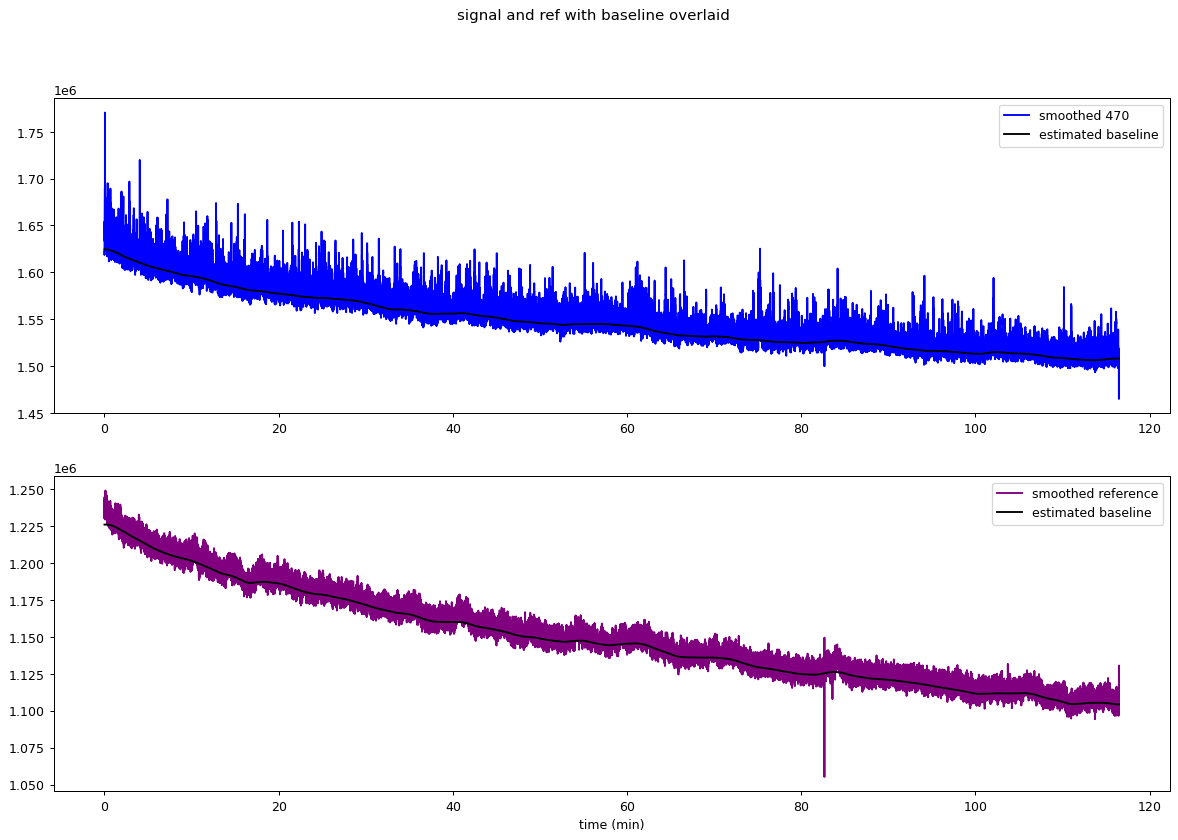

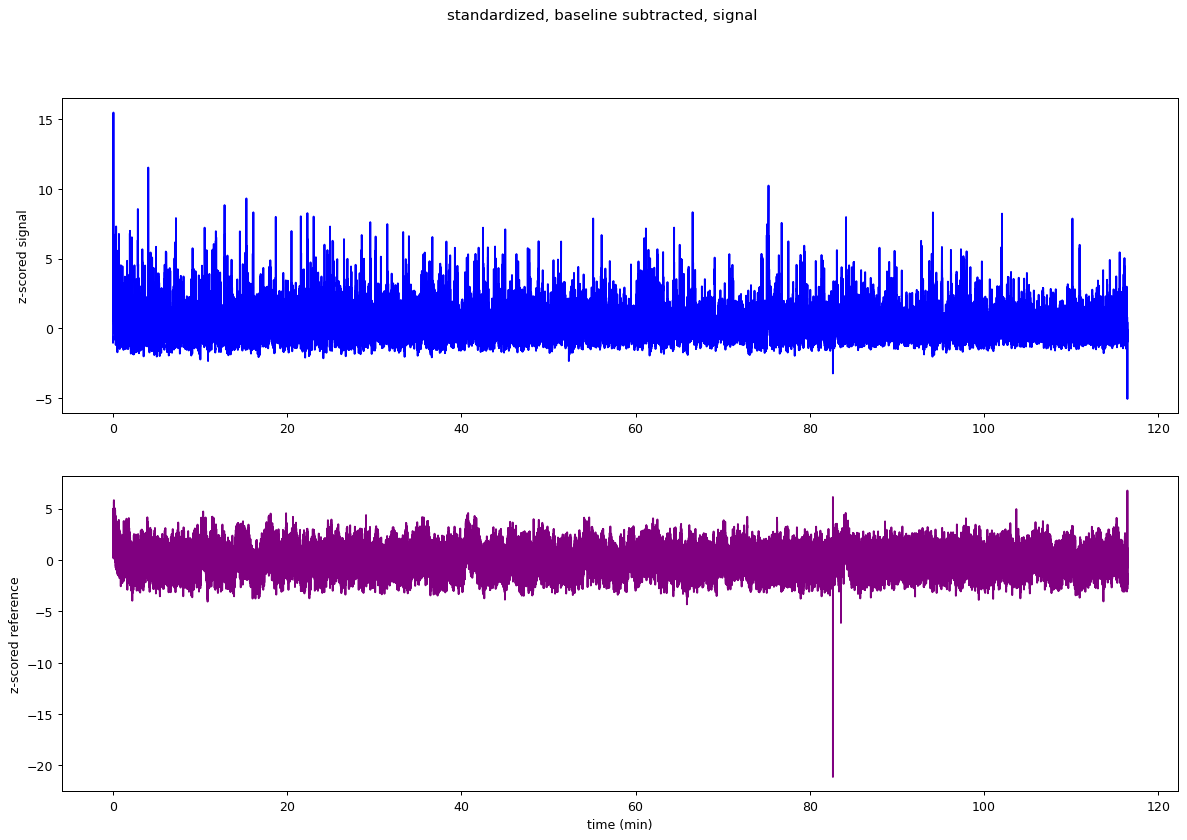

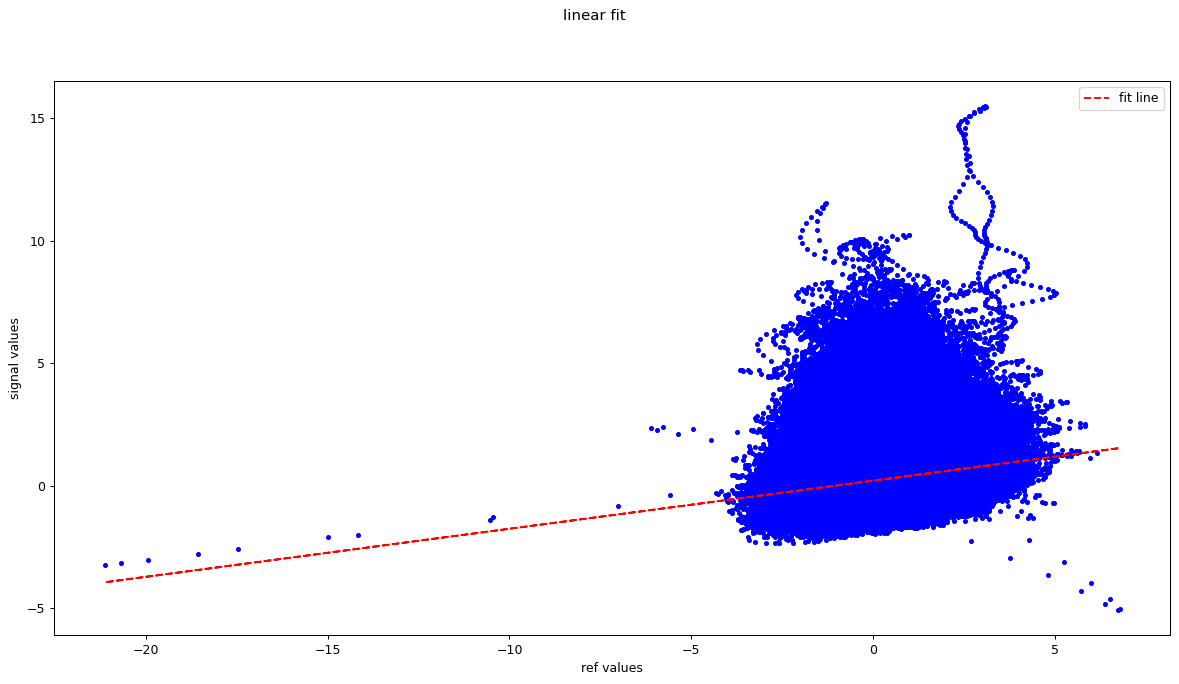

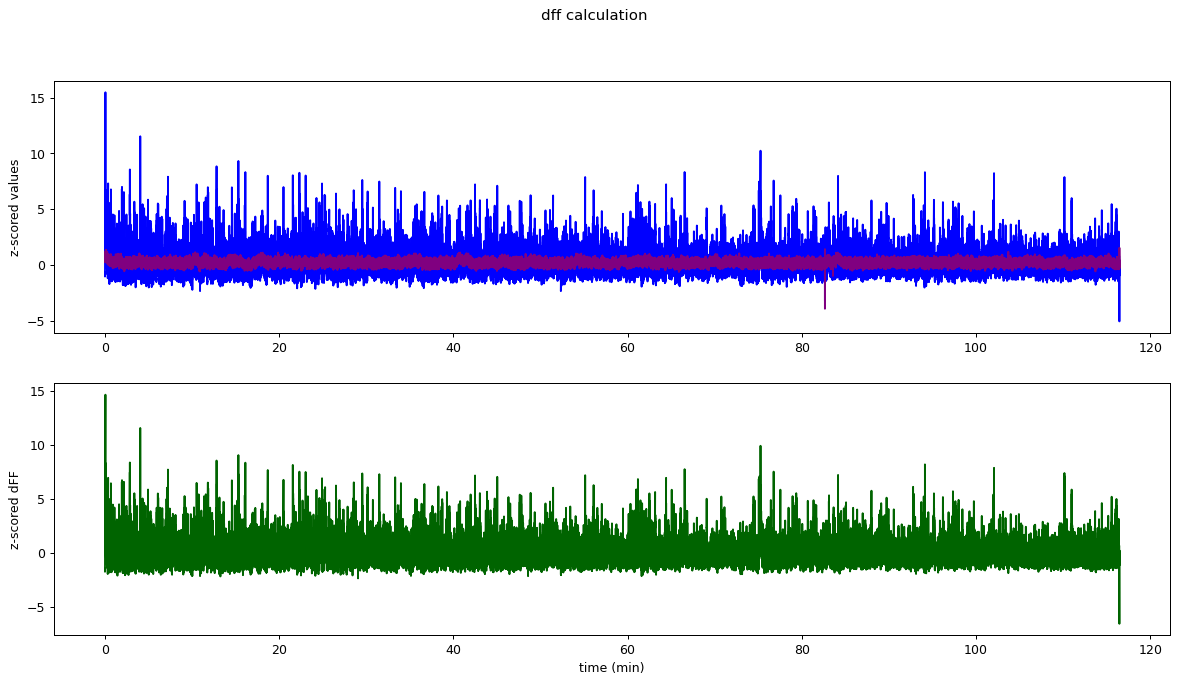

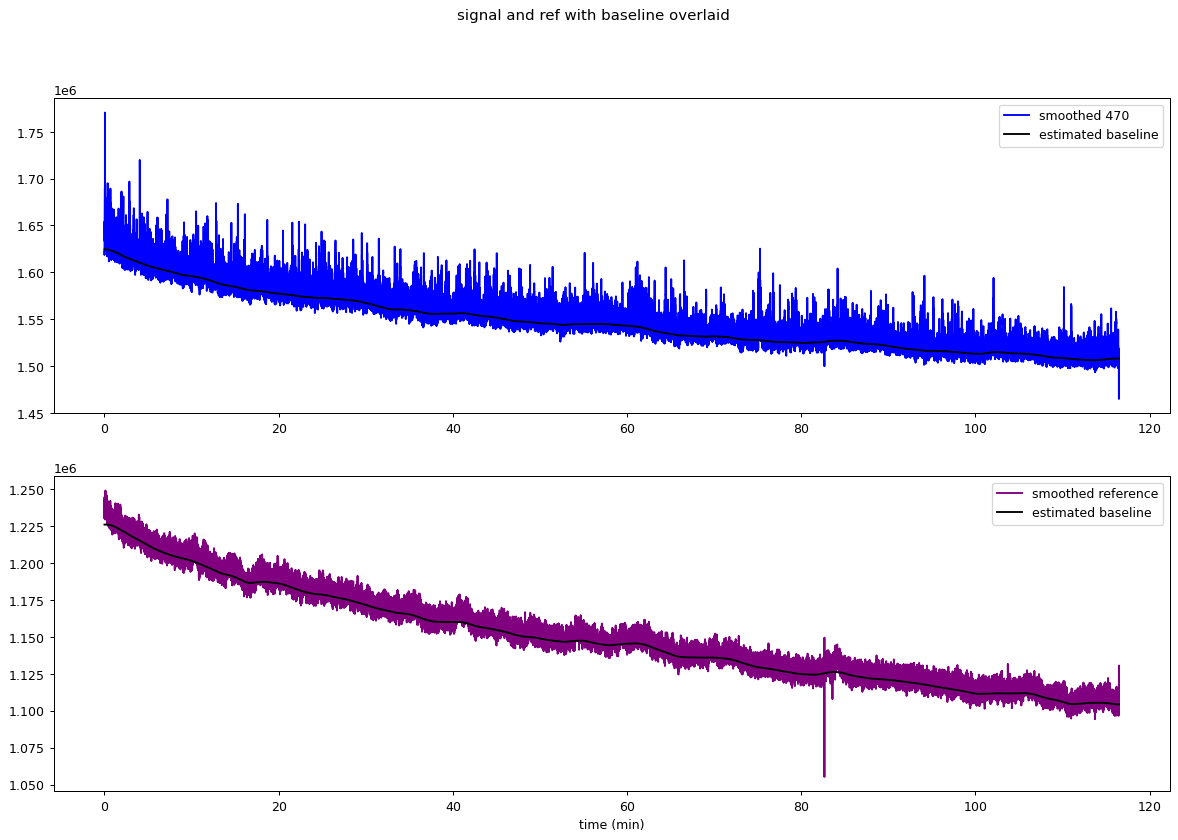

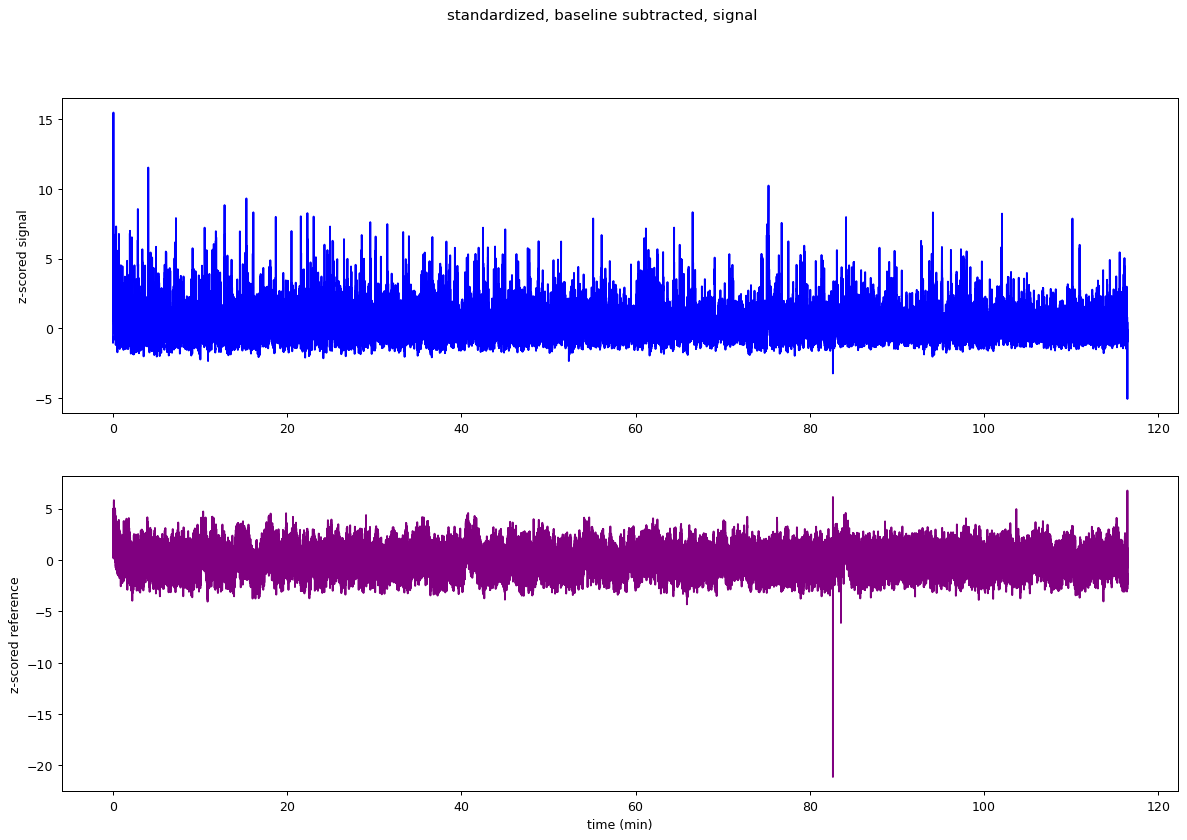

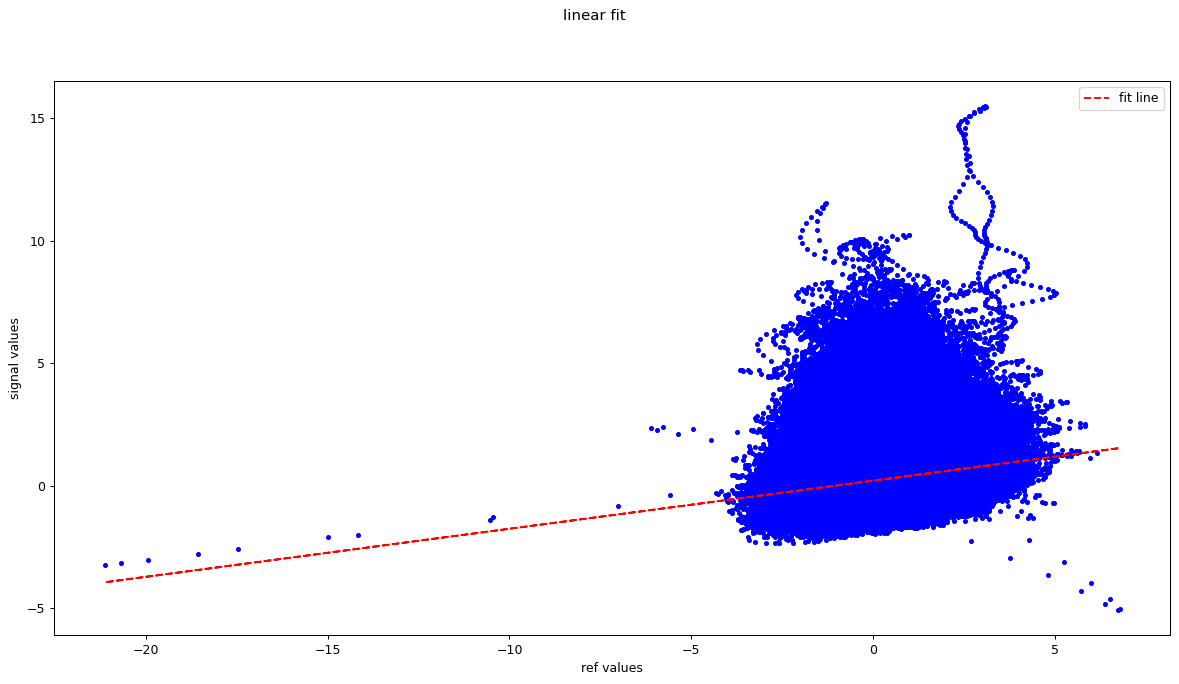

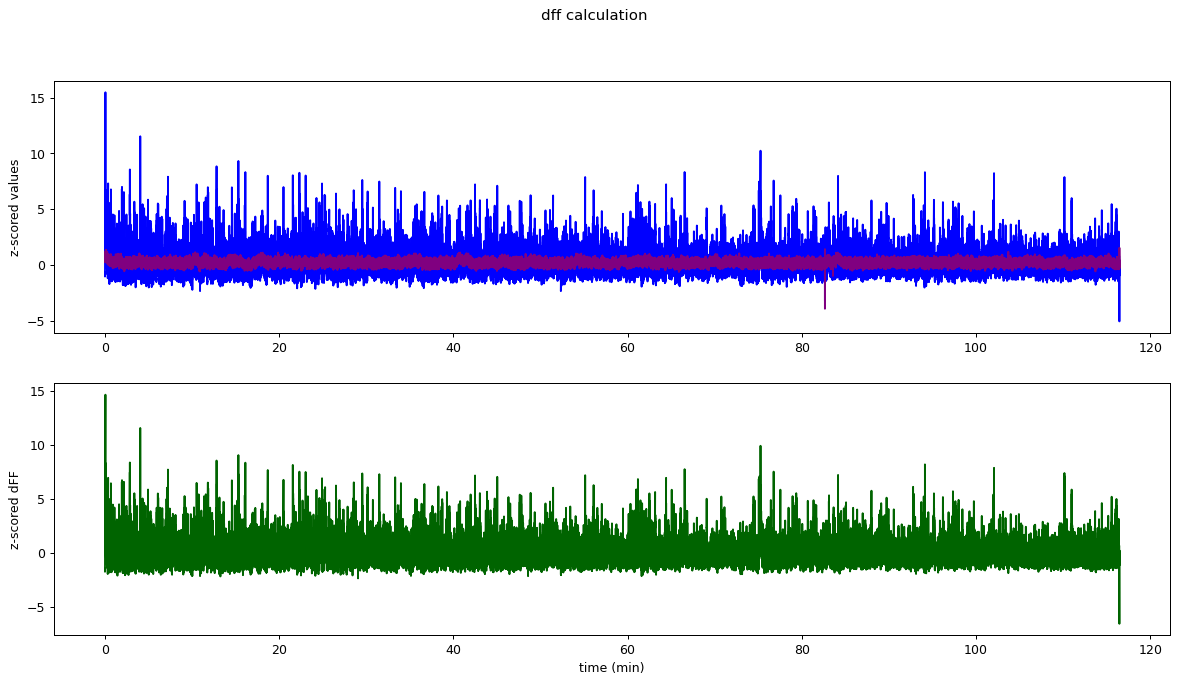

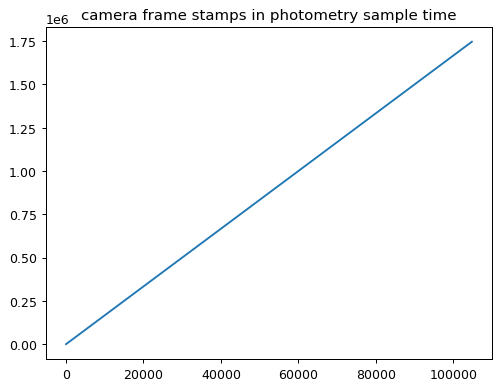

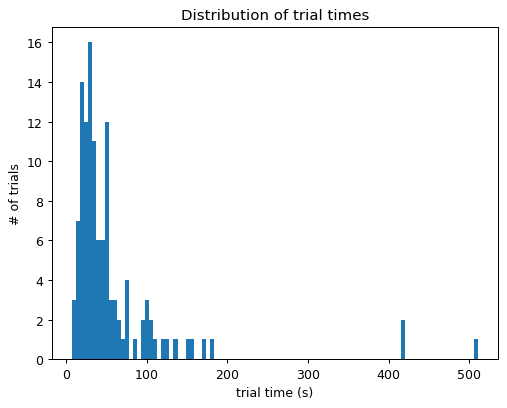

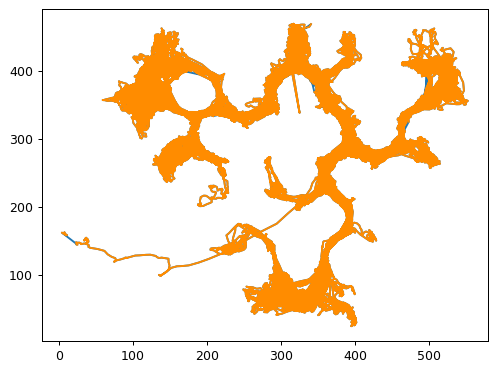

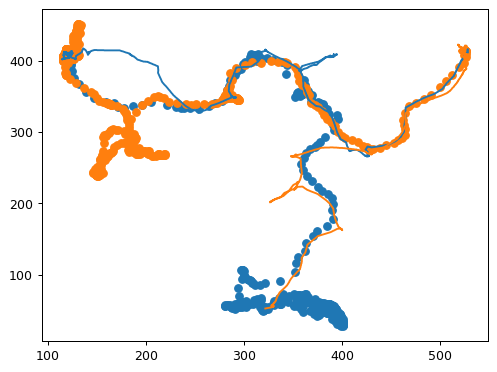

In [10]:
plt.plot(sampledata.loc[visinds[i+0]:visinds[i+1],'x'].interpolate(),sampledata.loc[visinds[i+0]:visinds[i+1],'y'].interpolate())
plt.plot(sampledata.loc[visinds[i+1]:visinds[i+2],'x'].interpolate(),sampledata.loc[visinds[i+1]:visinds[i+2],'y'].interpolate())
i += 1

plt.show()

# if there is an aberrant point in the maze, where DLC labeled the rat every time the cap was obscured, you can nan that out here by specifying the ranges. 
## *Note: this must be done before interpolating between missing position values*

In [12]:
xBadRange = [520,535]
yBadRange = [440,454]
sampledata.loc[(sampledata.x>xBadRange[0])&(sampledata.x<xBadRange[1])\
              &(sampledata.y>yBadRange[0])&(sampledata.y<yBadRange[1]),['x','y']]=np.nan

In [ ]:
plt.figure()
plt.scatter(sampledata.loc[visinds[i+0]:visinds[i+1],'x'],sampledata.loc[visinds[i+0]:visinds[i+1],'y'])
plt.scatter(sampledata.loc[visinds[i+1]:visinds[i+2],'x'],sampledata.loc[visinds[i+1]:visinds[i+2],'y'])
i += 1

# if the video has been labeled using a cropped area, make sure to adjust position to account for the offset. x += 85

In [ ]:
sampledata.loc[:,"x"] = sampledata.loc[:,"x"].values+85

# flip y position values to fit with hex map

In [11]:
y_pos = sampledata.y.values
y_midpoint = 480/2
flipped_y_values = y_midpoint + (y_midpoint - y_pos)
sampledata.loc[:,"y"] = flipped_y_values

In [12]:
%matplotlib qt

# adjust hex map to fit the video

In [13]:
import imageio
fname = datepath+'Behav_Vid'+filecount+'.avi'
vid = imageio.get_reader(fname, 'ffmpeg')

from fit_hex_grid import *
hexmap = HexMap(None,None,
                None,ses_type)

### transform_scatter will transform the scatter plot of hexes to fit the new map. the coordinates for each transformed centroid will be stored in the "new_coords" variable (in order of hex ID). You can access the transform parameters in the global variable "transformParams"

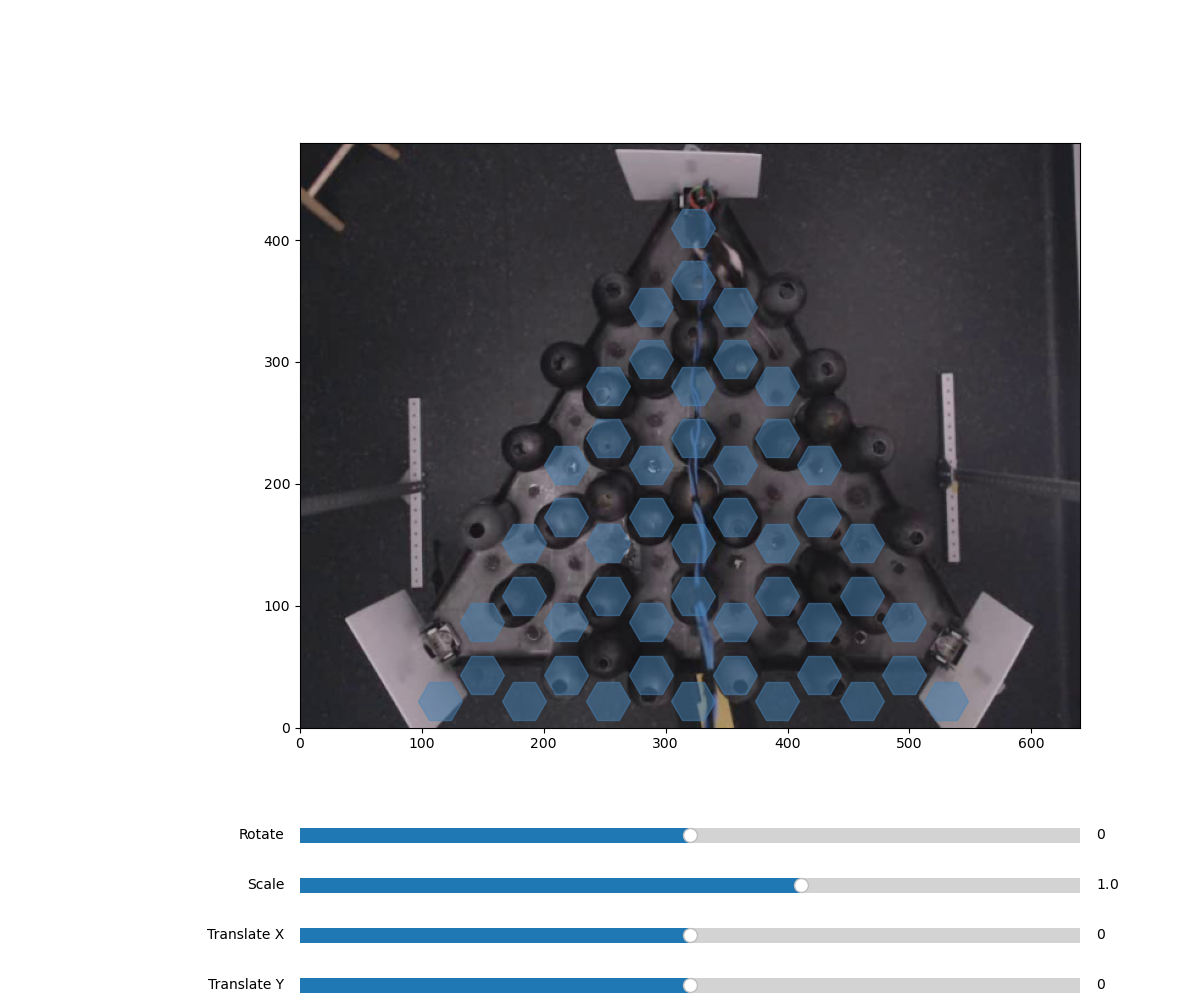

In [14]:
transform_scatter(np.hstack([centroids,np.ones((len(centroids),1))]),vid.get_data(1000),rotate_center=[640/2,480/2])

In [15]:
transformParams

[-0.2155480018028939, 0.9439449055989582, 18.56301332131403, 58.56301332131403]

### save the transform parameters for quick future access

In [16]:
np.save(datepath+"transformparams.npy",transformParams)
print("latest saved in "+datepath+"transformparams.npy")

latest saved in W:/Photometry/IM-1478/07202022/transformparams.npy


### load transform parameters if fit has already been established and saved

In [13]:
paramLoadPath = "W:/Photometry/IM-1566/04252023/"
[rotate_deg,scale,translate_x,translate_y] = np.load(paramLoadPath+"transformparams.npy")

points = np.hstack([centroids,np.ones((len(centroids),1))])

rotate_center=[640/2,480/2]
# Scale
scale_matrix = np.array([[scale, 0, 0],
                         [0, scale, 0],
                         [0, 0, 1]])

# Translate
translate_matrix = np.array([[1, 0, translate_x],
                             [0, 1, translate_y],
                             [0, 0, 1]])

# Rotate
rotate_rad = np.deg2rad(rotate_deg)
rotate_matrix = np.array([[np.cos(rotate_rad), -np.sin(rotate_rad), 0],
                          [np.sin(rotate_rad), np.cos(rotate_rad), 0],
                          [0, 0, 1]])

# Rotate around specified center
center_matrix = np.array([[1, 0, rotate_center[0]],
                          [0, 1, rotate_center[1]],
                          [0, 0, 1]])
center_translate_matrix = np.array([[1, 0, -rotate_center[0]],
                                    [0, 1, -rotate_center[1]],
                                    [0, 0, 1]])
rotate_around_center_matrix = center_translate_matrix.dot(rotate_matrix).dot(center_matrix)

# Transform points
transform_matrix = rotate_around_center_matrix.dot(scale_matrix).dot(translate_matrix)
transformed_points = transform_matrix.dot(points.T).T

new_coords = transformed_points[:,:2]

In [14]:
print(rotate_deg,scale,translate_x,translate_y)

1.201923076923066 0.7685897435897435 100.9615384615384 74.03846153846149


# identify barriers
## *be sure to click on the base of the barrier (where the overlaid hex is), not the top.*

In [17]:
all_bars = []
bind = 0

In [18]:
blocks = sampledata.block.unique()

max ind =  1


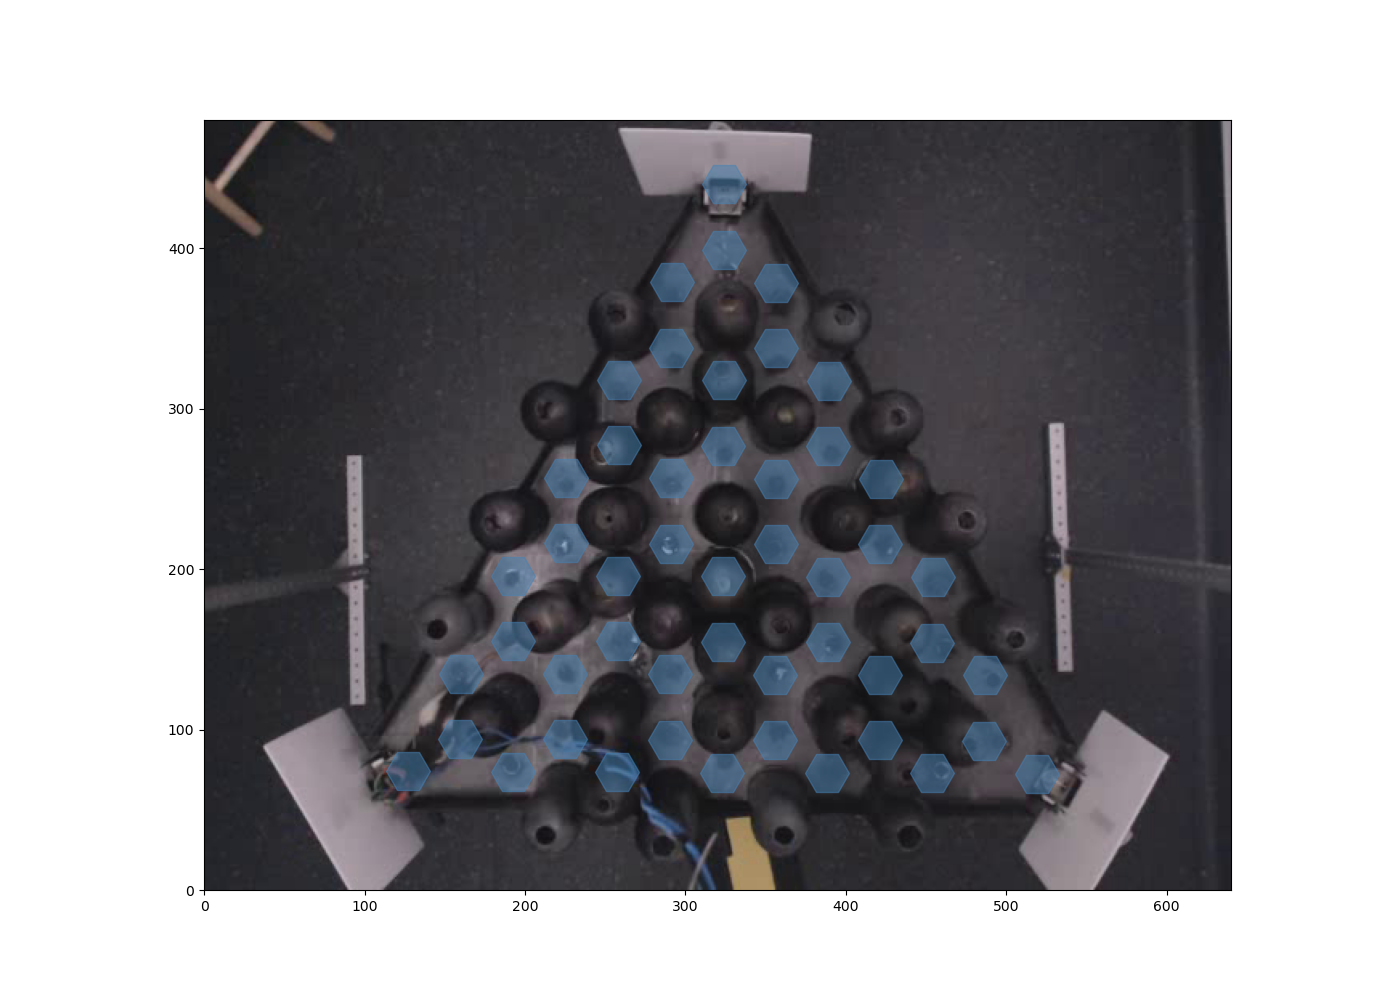

In [19]:
def onclick(event):
    global ix, iy
    ix, iy = event.xdata, event.ydata
    print("x = %d, y = %d" % (ix, iy))
    bar_coords.append((ix, iy))
print('max ind = ',len(blocks)-1)
b = blocks[bind]
ind = int(sampledata.loc[sampledata.block==b].index[int(250*300)]/250*15) #5min into block
fig,ax = plt.subplots(figsize=(14,10))
ax.imshow(vid.get_data(ind), extent=[0, 640, 0, 480])
plt.scatter(new_coords[:,0],new_coords[:,1],marker='H',color='steelblue',alpha=0.5,s=1000)
#for h in range(len(hexmap.ids)):
#    plt.text(hexmap.new_hexes[h].centroid.x-10,hexmap.new_hexes[h].centroid.y+10,hexmap.ids[h],\
#            color='whitesmoke',fontweight='demibold')
bar_coords = []
# connect the click event handler
cid = fig.canvas.mpl_connect('button_press_event', onclick)

# show the plot
plt.show()

In [20]:
bar_coords

[(324.17529931006493, 318.4220783184101),
 (258.72075385551943, 276.72510835721897),
 (422.66880580357133, 260.6558473265016),
 (259.96750710227263, 198.24891880580356),
 (324.17529931006493, 195.7554123122971),
 (326.0454291801948, 155.8593084161932),
 (421.42205255681813, 135.91125646814123),
 (420.7986759334415, 98.50865906554382),
 (256.8506239853896, 74.19697075385552)]

In [94]:
all_bars.append(assign_to_hexagon(np.array(bar_coords)[:,0],np.array(bar_coords)[:,1],new_coords))
bind += 1

# convert position to hex ID

In [95]:
hexes = assign_to_hexagon(sampledata.loc[sampledata.x.notnull(),'x'],sampledata.loc[sampledata.x.notnull(),'y'],new_coords)

ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

## sanity check that position is getting binned in the correct hexes

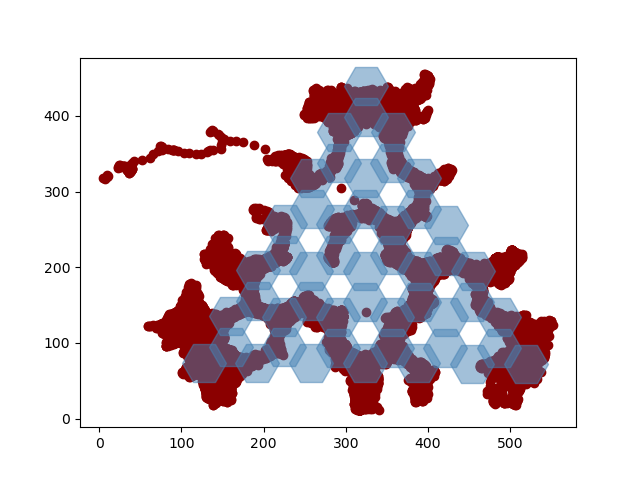

In [23]:
plt.figure()
plt.scatter(sampledata.loc[sampledata.x.notnull(),'x'].values,sampledata.loc[sampledata.x.notnull(),'y'].values,color='darkred')
plt.scatter(new_coords[:,0],new_coords[:,1],marker='H',color='steelblue',alpha=0.5,s=1000)

In [24]:
def plot_pos_and_its_hex(i):
    plt.clf()
    plt.scatter(sampledata.loc[sampledata.x.notnull(),'x'].values[i],sampledata.loc[sampledata.x.notnull(),'y'].values[i])
    plt.scatter(new_coords[:,0],new_coords[:,1],marker='H',color='steelblue',alpha=0.5,s=1000)
    plt.scatter(new_coords[hexes[i]-1,0],new_coords[hexes[i]-1,1],marker='H',color='darkred',alpha=0.5,s=1000)

interactive(children=(IntSlider(value=20000, description='frame #:', max=104366, min=1), Output()), _dom_class…

<function __main__.plot_pos_and_its_hex(i)>

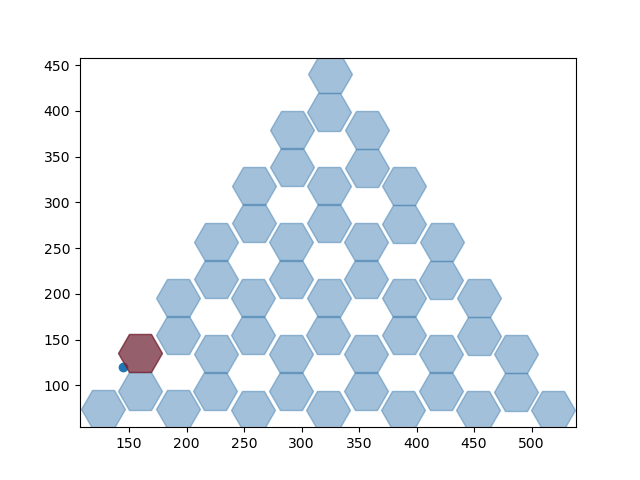

In [151]:
plt.figure()
interact(plot_pos_and_its_hex,i = widgets.IntSlider(
    value=20000,
    min=1,
    max=len(sampledata.loc[sampledata.x.notnull(),'x']),
    step=1,
    description='frame #:'))

In [ ]:
#seshdat = Photrat(animal,date)
#seshdat.df = sampledata

In [26]:
all_bars

[array([10, 14, 15, 26, 25, 30, 34, 39, 46], dtype=int64)]

In [ ]:
all_bars[2]

In [ ]:
#only when you have island
all_bars[2] = np.concatenate([all_bars[2],[11]])

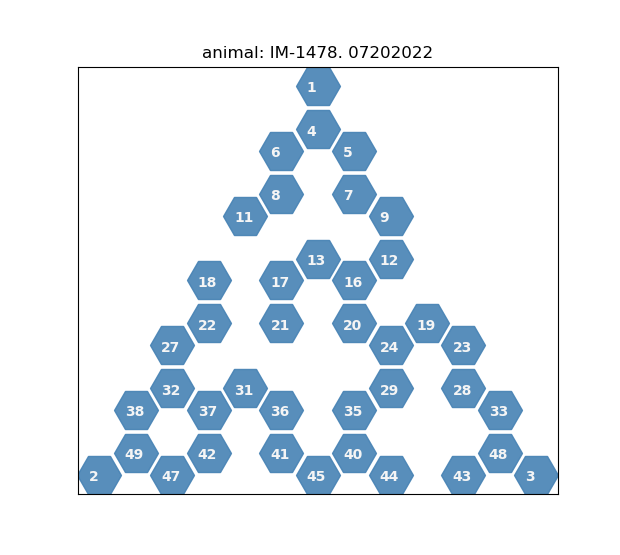

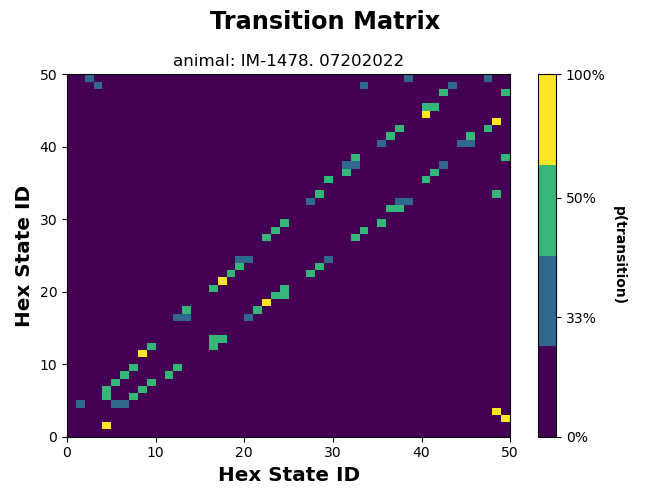

In [27]:
#seshdat.barIDs = np.array(barrier_ids)
#if barrier session, do for each block
#seshdat.tmats = {b:[] for b in np.arange(len(blocks))}
if ses_type == 'barrier':
    segments = []
    branches = []
    for b in range(len(blocks)):
        hexmap.bar_ids = all_bars[b]
        hexmap.bar_ids = [float(f) for f in hexmap.bar_ids]
        mapfig = plot_hex_outline(size='lg',bars=hexmap.bar_ids)
        mapfig.savefig(datepath+"/hex_layout_block"+str(blocks[b])+".pdf")
        plt.title('animal: '+animal+'. Block '+str(blocks[b])+'. '+date)
        transition_matrix = hexmap.plot_sesh_tmat(blocks[b])
        #seshdat.tmats[b] = transition_matrix
        plt.title('animal: '+animal+'. Block '+str(blocks[b])+'. '+date)
        plt.tight_layout()
        np.save(datepath+"/tmat_block_"+str(blocks[b]),transition_matrix)
    np.save(datepath+'/segments',segments)
else:
    hexmap.bar_ids = all_bars[0]
    hexmap.bar_ids = [float(f) for f in hexmap.bar_ids]
    mapfig = plot_hex_outline(size='lg',bars=hexmap.bar_ids)
    mapfig.savefig(datepath+"/hex_layout.pdf")
    plt.title('animal: '+animal+'. '+date)
    transition_matrix = hexmap.plot_sesh_tmat()
    #seshdat.tmats[0] = transition_matrix
    plt.title('animal: '+animal+'. '+date)
    plt.tight_layout()
    np.save(datepath+"/tmat",transition_matrix)

# mark critical choice points (where rat has option to choose one port with left choice, and a different port with right choice)

In [28]:
cps = np.load(datepath+"/cps.npy")

In [29]:
cps

array([24], dtype=int64)

In [32]:
crit_cps = [[24]]
if ses_type == 'barrier':
    for b in range(len(blocks)):
        np.save(datepath+"/cps_block_"+str(blocks[b]),crit_cps[b])
else:
    np.save(datepath+"/cps",crit_cps[0])

# add hexes to dataframe

In [30]:
sampledata.loc[:,'hexlabels'] = -1
sampledata.loc[sampledata.x.notnull(),'hexlabels'] = hexes
sampledata.loc[:,'hexlabels'] = sampledata.loc[:,'hexlabels'].replace(-1,method='ffill')

C:\Users\yangsunhwang\AppData\Local\Temp\ipykernel_26680\3432592372.py:3: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  sampledata.loc[:,'hexlabels'] = sampledata.loc[:,'hexlabels'].replace(-1,method='ffill')


# save final dataframe

In [31]:
sampledata.to_csv(savepath+animal+'_'+date+'_'+'h_sampleframe_byYS.csv')

## check and save reward response of DA

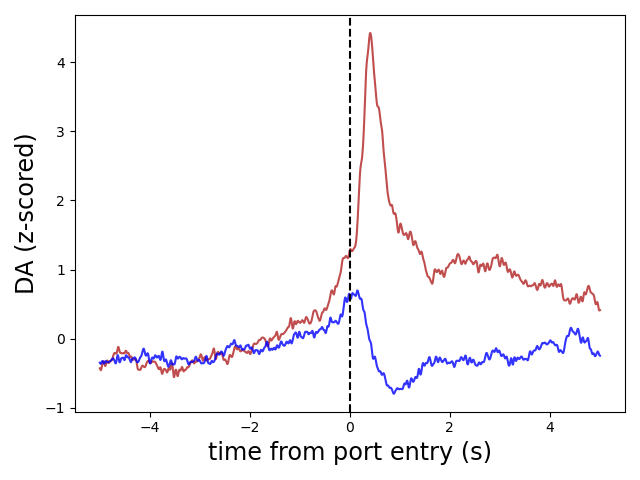

In [32]:
rwd_traces = []
om_traces = []
xvals = np.arange(-5*250,5*250+1)/250
for i in visinds:
    if sampledata.loc[i,'rwd']==1:
        rwd_traces.append(sampledata.loc[i-250*5:i+250*5,"green_z_scored"].values)
    else:
        trace = sampledata.loc[i-250*5:i+250*5,"green_z_scored"].values
        if len(trace)==len(xvals):
            om_traces.append(trace)
fig = plt.figure()
plt.plot(xvals,np.mean(rwd_traces,axis=0),color='firebrick',alpha=0.8)
plt.plot(xvals,np.mean(om_traces,axis=0),color='blue',alpha=0.8)
plt.axvline(x=0,ls='--',color='k')
plt.xlabel("time from port entry (s)",fontsize='xx-large')
plt.ylabel("DA (z-scored)",fontsize='xx-large')
plt.tight_layout()
fig.savefig(datepath+"meanRwdOmRespone.pdf")

# Let's compare Tims' first early session

In [33]:
import os
import sys
path1 = r'C:\\Users\\yangsunhwang\\Documents\\GitHub\\HC_decode_analyses\\Modules'
#sys.path += [path1]\n",
os.chdir(path1)
print(os.getcwd())

C:\Users\yangsunhwang\Documents\GitHub\HC_decode_analyses\Modules


In [34]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import find_peaks,correlate,correlation_lags
import statsmodels.api as sm
from scipy.stats import sem
from statsmodels.tsa.stattools import ccf
from photPlusDecode_funcs import *
%matplotlib qt

In [167]:
sampledata_old = pd.read_csv(r"W:/Ephys/IM-1594/07282023/phot_decode_df_withHexStates.csv")
sampledata_old = reduce_mem_usage(sampledata_old)

Memory usage of dataframe is 700.21 MB
Memory usage after optimization is: 183.63 MB
Decreased by 73.8%


- oops, let's add pairedHexStates to my new dataframe

In [165]:
sampledata.loc[:,"pairedHexStates"] = -1
sampledata.loc[sampledata.hexlabels.diff()!=0,"pairedHexStates"] = convert2pairedState(sampledata.loc[sampledata.hexlabels.diff()!=0,"hexlabels"].values)
sampledata.loc[:,"pairedHexStates"] = sampledata.loc[:,"pairedHexStates"].replace(-1,method="ffill")

- comparison time!

In [139]:
sampledata_old.columns

Index(['Unnamed: 0.1', 'level_0', 'index', 'Unnamed: 0', 'x', 'y', 'green',
       'port', 'rwd', 'block', 'pA', 'pB', 'pC', 'frame', 'ref', 'vel', 'acc',
       'tri', 'fromP', '470', 'beamA', 'beamB', 'beamC', 'tot_tri',
       'green_z_scored', 'fiberloc', 'session_type', 'rat', 'date', 'nextprob',
       'nextp', 'lenAC', 'lenBC', 'lenAB', 'simple_rr', 'pchosen', 'dtop',
       'nom_rwd_a', 'nom_rwd_b', 'nom_rwd_c', 'hexlabels', 'decodeDistToRat',
       'decodeHPD', 'x_pred', 'y_pred', 'mua', 'theta_env', 'theta_phase',
       'theta_phase_bin', 'pred_hexlabels', 'pred_hexState'],
      dtype='object')

## I found the problem.
- (Although still we might need to double check the location-) there is -1 intermediating the actually labeled hexes. I will fill the -1 of Tim's old data

In [169]:
sampledata_old.loc[sampledata_old.hexlabels.diff()!=0, ['index', 'port', 'x', 'y', 'tri','hexlabels']]

index  port        x         y   tri  hexlabels
0           5641  -100      NaN       NaN   1.0         -1
7           5648  -100  476.750   96.0000   1.0          3
8           5649  -100  476.750   96.0625   1.0         -1
21          5662  -100  476.500   96.5000   1.0          3
22          5663  -100  476.500   96.5000   1.0         -1
...          ...   ...      ...       ...   ...        ...
1798113  1803754  -100  243.625  299.2500  35.0         -1
1798130  1803771  -100  244.500  299.5000  35.0         11
1798131  1803772  -100  244.625  299.5000  35.0         -1
1798146  1803787  -100  247.125  299.0000  35.0         11
1798147  1803788  -100  247.125  299.0000  35.0         -1

[200169 rows x 6 columns]

In [170]:
sampledata_old.loc[:,"hexlabels"] = sampledata_old.loc[:,"hexlabels"].replace(-1,method="ffill")

C:\Users\yangsunhwang\AppData\Local\Temp\ipykernel_26680\3539977685.py:1: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  sampledata_old.loc[:,"hexlabels"] = sampledata_old.loc[:,"hexlabels"].replace(-1,method="ffill")


In [171]:
len(sampledata_old.loc[sampledata_old.hexlabels.diff()!=0, ['index', 'port', 'x', 'y', 'tri','hexlabels']])

4837

## now, I am adding pairedHexStates to my Tim's incomplete dataset

In [173]:
sampledata_old.loc[:,"pairedHexStates"] = -1
sampledata_old.loc[sampledata_old.hexlabels.diff()!=0,"pairedHexStates"] = convert2pairedState(sampledata_old.loc[sampledata_old.hexlabels.diff()!=0,"hexlabels"].values)
sampledata_old.loc[:,"pairedHexStates"] = sampledata_old.loc[:,"pairedHexStates"].replace(-1,method="ffill")

C:\Users\yangsunhwang\AppData\Local\Temp\ipykernel_26680\190104341.py:3: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  sampledata_old.loc[:,"pairedHexStates"] = sampledata_old.loc[:,"pairedHexStates"].replace(-1,method="ffill")


In [174]:
len(sampledata_old.loc[sampledata_old.hexlabels.diff()!=0, ['index', 'port', 'x', 'y', 'tri','hexlabels', 'pairedHexStates']])

4837

In [175]:
len(sampledata_old.loc[sampledata_old.pairedHexStates.diff()!=0, ['index', 'port', 'x', 'y', 'tri','hexlabels', 'pairedHexStates']])

4224

In [176]:
sampledata_old.loc[sampledata_old.hexlabels.diff()!=0, ['index', 'port', 'x', 'y', 'tri','hexlabels', 'pairedHexStates']]

index  port       x       y   tri  hexlabels  pairedHexStates
0           5641  -100     NaN     NaN   1.0         -1               -1
7           5648  -100  476.75   96.00   1.0          3               -1
513         6154  -100  457.25   90.25   1.0         48                2
701         6342  -100  434.75   84.75   1.0         43              122
929         6570  -100  409.50   95.50   1.0         39              110
...          ...   ...     ...     ...   ...        ...              ...
1781710  1787351  -100  316.75  263.00  35.0         10               26
1782618  1788259  -100  319.75  260.50  35.0         13               20
1784182  1789823  -100  314.75  268.75  35.0         10               26
1785063  1790704  -100  302.50  291.00  35.0          8               19
1785315  1790956  -100  270.75  288.00  35.0         11               15

[4837 rows x 7 columns]

- if you are happy, save this file. But keep Tim's old file in case you want (rename old one adding _byTim)

In [177]:
sampledata_old.to_csv('W:/Ephys/IM-1594/07282023/phot_decode_df_withHexStates.csv')

In [149]:
sampledata_old

Unnamed: 0.1  level_0    index  Unnamed: 0       x       y     green  \
0                   0     5671     5671        5671  475.50   86.75 -0.582031   
1                   1     5672     5672        5672  475.50   87.00 -0.604980   
2                   2     5673     5673        5673  475.50   87.00 -0.625977   
3                   3     5674     5674        5674  475.50   87.00 -0.639160   
4                   4     5675     5675        5675  475.75   87.00 -0.638672   
...               ...      ...      ...         ...     ...     ...       ...   
1792005       1792005  1797676  1797676     1797676  140.50  129.25  0.751953   
1792006       1792006  1797677  1797677     1797677  140.50  129.25  0.740234   
1792007       1792007  1797678  1797678     1797678  140.50  129.25  0.698730   
1792008       1792008  1797679  1797679     1797679  140.50  129.25  0.627441   
1792009       1792009  1797680  1797680     1797680  140.50  129.25  0.526367   

         port  rwd  block  ...  decodeHPD  x_pred   y_pred       mua  \
0        -100    0    1.0  ...     611.00  491.50   68.375  4.082031   
1        -100    0    1.0  ...     457.50  482.25   68.375  4.347656   
2        -100    0    1.0  ...     414.00  482.25   68.375  4.597656   
3        -100    0    1.0  ...     414.00  482.25   68.375  4.808594   
4        -100    0    1.0  ...     425.75  482.25   68.375  4.984375   
...       ...  ...    ...  ...        ...     ...      ...       ...   
1792005  -100    0    1.0  ...     311.50  277.00  365.500  0.000000   
1792006  -100    0    1.0  ...     323.25  277.00  365.500  0.000000   
1792007  -100    0    1.0  ...     339.00  277.00  365.500  0.000000   
1792008  -100    0    1.0  ...     366.75  277.00  365.500  0.000000   
1792009  -100    0    1.0  ...     406.25  277.00  365.500  0.000000   

         theta_env  theta_phase   theta_phase_bin  pred_hexlabels  \
0         1.250977    -1.512695  (-1.692, -1.208]               3   
1         1.250977    -1.360352  (-1.692, -1.208]               3   
2         1.250977    -1.156250  (-1.208, -0.725]               3   
3         1.250977    -0.937012  (-1.208, -0.725]               3   
4         1.250977    -0.715820  (-0.725, -0.242]               3   
...            ...          ...               ...             ...   
1792005   0.068970    -1.570312  (-1.692, -1.208]               6   
1792006   0.068909    -1.570312  (-1.692, -1.208]               6   
1792007   0.068909    -1.570312  (-1.692, -1.208]               6   
1792008   0.068909    -1.570312  (-1.692, -1.208]               6   
1792009   0.068909    -1.570312  (-1.692, -1.208]               6   

         pred_hexState  pairedHexStates  
0                   -1               -1  
1                   -1               -1  
2                   -1               -1  
3                   -1               -1  
4                   -1               -1  
...                ...              ...  
1792005             -1              123  
1792006             -1              123  
1792007             -1              123  
1792008             -1              123  
1792009             -1              123  

[1792010 rows x 52 columns]

## Well done! Please move forward

In [131]:
sampledata_old.loc[(sampledata_old.tri==8) & sampledata_old.hexlabels.diff()!=0, ['index', 'port', 'x', 'y', 'tri','hexlabels']].head(50)

index  port        x        y  tri  hexlabels
55569    56225  -100  326.750  357.500  8.0          4
55764    56420  -100  297.500  343.000  8.0          6
56562    57218  -100  310.500  340.750  8.0          4
56630    57286  -100  337.500  306.500  8.0          7
56739    57395  -100  369.000  252.625  8.0         12
56801    57457  -100  349.000  234.125  8.0         16
56874    57530  -100  342.500  204.500  8.0         20
57377    58033  -100  326.250  181.500  8.0         25
57445    58101  -100  315.500  160.500  8.0         30
57549    58205  -100  300.500  138.750  8.0         36
58837    59493  -100  285.250  111.000  8.0         41
59531    60187  -100  301.500   88.000  8.0         45
60310    60966  -100  329.000   85.500  8.0         40
62118    62774  -100  327.500   87.000  8.0         45
62139    62795  -100  329.000   87.750  8.0         40
62186    62842  -100  323.500   82.000  8.0         45
62537    63193  -100  350.750   93.000  8.0         40
62602    63258  -100  361.250   94.250  8.0         44
62654    63310  -100  388.000   87.750  8.0         39
62728    63384  -100  412.000   86.000  8.0         43
62780    63436  -100  440.000   85.250  8.0         48
62914    63570  -100  463.000   81.750  8.0          3
372693  373349  -100  316.000  354.500  8.0          4
372759  373415  -100  302.500  334.500  8.0          6
372915  373571  -100  292.250  309.000  8.0          8
372983  373639  -100  275.000  285.500  8.0         11
373192  373848  -100  261.500  261.500  8.0         14
373311  373967  -100  242.250  241.750  8.0         18
373453  374109  -100  250.375  244.000  8.0         14
373727  374383  -100  255.875  269.750  8.0         11
373802  374458  -100  278.250  286.500  8.0          8
374006  374662  -100  309.750  332.000  8.0          4
374071  374727  -100  335.500  330.500  8.0          5
374159  374815  -100  345.750  294.000  8.0          7
374207  374863  -100  367.500  269.500  8.0          9
374245  374901  -100  365.000  253.000  8.0         12
374311  374967  -100  353.000  223.000  8.0         16
374350  375006  -100  341.000  207.500  8.0         20
374402  375058  -100  326.000  183.500  8.0         25
374467  375123  -100  302.250  149.250  8.0         30
374503  375159  -100  288.250  142.750  8.0         36
374535  375191  -100  276.500  140.500  8.0         31
374607  375263  -100  236.500  140.250  8.0         37
374639  375295  -100  216.125  134.500  8.0         32
374691  375347  -100  194.250  139.000  8.0         38
374779  375435  -100  154.500  108.250  8.0          2
668180  668836  -100  318.000  360.000  8.0          4
668421  669077  -100  329.500  333.250  8.0          5
668493  669149  -100  328.000  333.500  8.0          4
668524  669180  -100  329.000  333.250  8.0          5

In [164]:
sampledata_old.loc[(sampledata_old.tri==8) & sampledata_old.hexlabels.diff()!=0, ['port', 'x', 'y', 'tri','hexlabels','pairedHexStates']].head(50)

port        x         y  tri  hexlabels  pairedHexStates
19889   -100  350.500   68.1875    8        4.0                3
20605   -100  362.500   90.0625    8        5.0                4
20705   -100  360.250  137.5000    8        7.0                7
20805   -100  391.000  191.1250    8       12.0               17
20889   -100  370.000  225.0000    8       16.0               25
20957   -100  351.250  257.7500    8       20.0               36
21205   -100  387.500  294.7500    8       24.0               46
21457   -100  392.500  316.7500    8       29.0               58
23805   -100  377.000  343.0000    8       35.0               72
24341   -100  370.250  368.7500    8       40.0               89
24521   -100  372.500  402.0000    8       44.0              102
24689   -100  372.500  389.5000    8       40.0              102
24821   -100  318.250  405.7500    8       45.0              103
24889   -100  305.250  396.7500    8       41.0              115
24973   -100  285.000  358.5000    8       36.0              104
25021   -100  272.500  340.7500    8       31.0               91
25141   -100  223.875  335.0000    8       37.0               78
25189   -100  193.125  339.5000    8       32.0               94
25257   -100  155.500  347.0000    8       38.0               81
25289   -100  139.375  361.2500    8       49.0               97
25321   -100  126.625  380.7500    8        2.0              123
711066  -100  498.250  407.0000    8       48.0                2
711534  -100  479.500  343.2500    8       33.0              121
711550  -100  470.750  334.0000    8       28.0               82
711598  -100  461.000  304.5000    8       23.0               67
711650  -100  440.000  278.7500    8       19.0               54
711782  -100  392.500  278.7500    8       24.0               44
712834  -100  388.000  318.7500    8       29.0               58
713582  -100  375.500  344.5000    8       35.0               72
716098  -100  366.500  367.2500    8       40.0               72
716634  -100  372.500  399.2500    8       44.0               89
716850  -100  365.000  394.7500    8       40.0              113
717150  -100  326.500  405.7500    8       45.0              113
717766  -100  298.750  399.7500    8       41.0              115
717950  -100  282.250  359.2500    8       36.0              104
717982  -100  271.500  342.7500    8       31.0               91
718114  -100  227.875  333.7500    8       37.0               78
718182  -100  190.875  339.5000    8       32.0               94
718250  -100  156.500  345.5000    8       38.0               81
718283  -100  142.625  355.7500    8       49.0               97

In [166]:
sampledata.loc[(sampledata.tri==8) & (sampledata.hexlabels.diff()!=0),['port', 'x', 'y', 'tri','hexlabels','pairedHexStates']].head(50)

port        x       y  tri  hexlabels  pairedHexStates
54580    NaN  336.000  416.75  8.0          4                0
54895    NaN  330.250  419.50  8.0          1                3
54948    NaN  330.500  418.50  8.0          4                0
55096    NaN  363.250  419.00  8.0          5                4
55131    NaN  372.000  429.50  8.0          1               -1
55195    NaN  380.750  427.00  8.0          5               -1
55615    NaN  378.000  431.00  8.0          1               -1
55647    NaN  374.250  425.75  8.0          5               -1
55863    NaN  360.250  351.25  8.0          7                7
55947    NaN  382.250  316.00  8.0          9               11
55979    NaN  391.000  289.00  8.0         12               17
56063    NaN  370.000  255.00  8.0         16               25
56115    NaN  356.000  230.00  8.0         20               36
56347    NaN  374.500  201.25  8.0         24               46
56615    NaN  394.750  169.00  8.0         29               58
57063    NaN  372.500  139.00  8.0         35               72
57147    NaN  378.500  140.75  8.0         29               87
57463    NaN  372.750  142.50  8.0         35               72
57947    NaN  373.750  143.25  8.0         29               87
58047    NaN  376.500  137.00  8.0         35               72
58895    NaN  377.000  138.75  8.0         29               87
58995    NaN  371.250  133.50  8.0         35               72
59515    NaN  370.250  111.25  8.0         40               89
59695    NaN  372.500   78.00  8.0         44              102
59863    NaN  372.500   90.50  8.0         40              113
59963    NaN  342.250   75.25  8.0         45              103
60063    NaN  305.250   83.25  8.0         41              115
60147    NaN  285.000  121.50  8.0         36              104
60215    NaN  268.000  143.00  8.0         31               91
60295    NaN  235.250  147.50  8.0         37               78
60347    NaN  201.625  139.75  8.0         32               94
60395    NaN  172.250  144.75  8.0         38               81
60479    NaN  132.875  108.50  8.0         49               97
60495    NaN  126.625   99.25  8.0          2              123
746256   NaN  494.750   74.75  8.0         48                2
746672   NaN  494.750  118.50  8.0         33              121
746724   NaN  470.750  146.00  8.0         28               82
746772   NaN  461.000  175.50  8.0         23               67
746840   NaN  434.500  203.50  8.0         19               54
746924   NaN  403.500  205.00  8.0         24               44
747988   NaN  392.500  166.00  8.0         29               58
748756   NaN  375.500  135.50  8.0         35               72
751272   NaN  366.500  112.75  8.0         40               89
751808   NaN  372.500   80.75  8.0         44              102
752024   NaN  365.000   85.25  8.0         40              113
752288   NaN  336.000   87.25  8.0         45              103
752924   NaN  299.750   76.00  8.0         41              115
753108   NaN  284.250  116.75  8.0         36              104
753172   NaN  266.250  141.25  8.0         31               91
753272   NaN  233.625  148.75  8.0         37               78

In [79]:
hexlabels_changes=sampledata.loc[(sampledata.hexlabels.diff()!=0),"hexlabels"]
hexlabels_idx=sampledata.loc[(sampledata.hexlabels.diff()!=0)].index
hexstates_changes=sampledata.loc[(sampledata.pairedHexStates.diff()!=0),"pairedHexStates"]
hexstates_idx=sampledata.loc[(sampledata.pairedHexStates.diff()!=0)].index
print(" In sampledata, hexlabel changes "+str(len(hexlabels_changes))+" times and"\
      + " pairedhexstate changes "+str(len(hexstates_changes))+" times." \
      + " In those, " + str(len(hexstates_idx[hexstates_idx.isin(hexlabels_idx)])) +" has same index.")

 In sampledata, hexlabel changes 3676 times and pairedhexstate changes 3407 times. In those, 3407 has same index.


In [80]:
hexlabels_changes=sampledata.loc[(sampledata.tri>3) &(sampledata.hexlabels.diff()!=0),"hexlabels"]
hexlabels_idx=sampledata.loc[(sampledata.tri>3) &(sampledata.hexlabels.diff()!=0)].index
hexstates_changes=sampledata.loc[(sampledata.tri>3) &(sampledata.pairedHexStates.diff()!=0),"pairedHexStates"]
hexstates_idx=sampledata.loc[(sampledata.tri>3) &(sampledata.pairedHexStates.diff()!=0)].index
print(" In sampledata, hexlabel changes "+str(len(hexlabels_changes))+" times and"\
      + " pairedhexstate changes "+str(len(hexstates_changes))+" times." \
      + " In those, " + str(len(hexstates_idx[hexstates_idx.isin(hexlabels_idx)])) +" has same index.")

 In sampledata, hexlabel changes 3485 times and pairedhexstate changes 3224 times. In those, 3224 has same index.


In [77]:
hexlabels_changes=sampledata_old.loc[(sampledata_old.hexlabels.diff()!=0),"hexlabels"]
hexlabels_idx=sampledata_old.loc[(sampledata_old.hexlabels.diff()!=0)].index
hexstates_changes=sampledata_old.loc[(sampledata_old.pairedHexStates.diff()!=0),"pairedHexStates"]
hexstates_idx=sampledata_old.loc[(sampledata_old.pairedHexStates.diff()!=0)].index
print(" In old, Tim's sampledata, hexlabel changes "+str(len(hexlabels_changes))+" times and"\
      + " pairedhexstate changes "+str(len(hexstates_changes))+" times." \
      + " In those, " + str(len(hexstates_idx[hexstates_idx.isin(hexlabels_idx)])) +" has same index.")

 In old, Tim's sampledata, hexlabel changes 2455 times and pairedhexstate changes 2373 times. In those, 777 has same index.


# Let's bring up Tim's old sampledata and see how this matches with the map

- flip the y data first

In [82]:
y_pos = sampledata_old.y.values
y_midpoint = 480/2
flipped_y_values = y_midpoint + (y_midpoint - y_pos)
sampledata_old.loc[:,"y"] = flipped_y_values

- plot the location with hexes

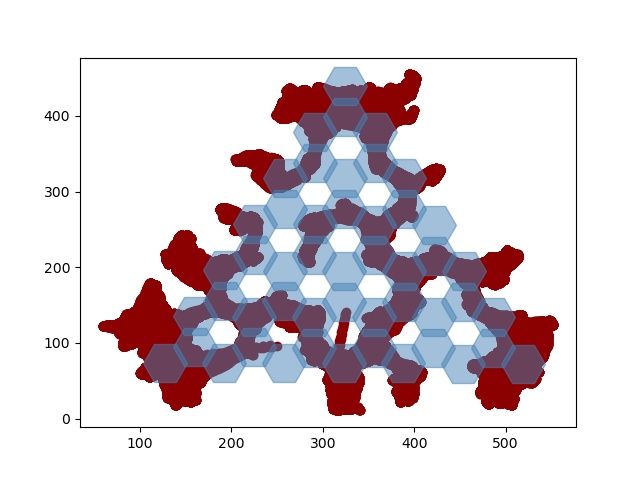

In [83]:
plt.figure()
plt.scatter(sampledata_old.loc[sampledata_old.x.notnull(),'x'].values,sampledata_old.loc[sampledata_old.x.notnull(),'y'].values,color='darkred')
plt.scatter(new_coords[:,0],new_coords[:,1],marker='H',color='steelblue',alpha=0.5,s=1000)

In [93]:
hexes_old = assign_to_hexagon(sampledata_old.loc[sampledata_old.x.notnull(),'x'],sampledata_old.loc[sampledata_old.x.notnull(),'y'],new_coords)

ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

In [84]:
def plot_pos_and_its_hex_old(i):
    plt.clf()
    plt.scatter(sampledata_old.loc[sampledata_old.x.notnull(),'x'].values[i],sampledata_old.loc[sampledata_old.x.notnull(),'y'].values[i])
    plt.scatter(new_coords[:,0],new_coords[:,1],marker='H',color='steelblue',alpha=0.5,s=1000)
    plt.scatter(new_coords[hexes_old[i]-1,0],new_coords[hexes_old[i]-1,1],marker='H',color='darkred',alpha=0.5,s=1000)

interactive(children=(IntSlider(value=20000, description='frame #:', max=104366, min=1), Output()), _dom_class…

<function __main__.plot_pos_and_its_hex_old(i)>

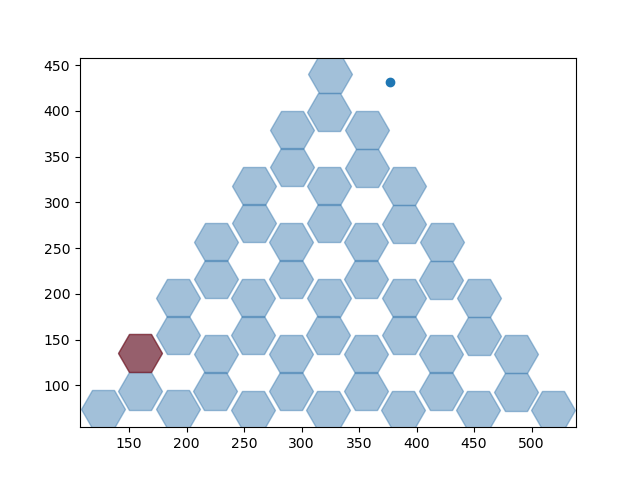

In [100]:
plt.figure()
interact(plot_pos_and_its_hex_old,i = widgets.IntSlider(
    value=20000,
    min=1,
    max=len(sampledata.loc[sampledata.x.notnull(),'x']),
    step=1,
    description='frame #:'))

In [89]:
len(new_coords)

49

In [152]:
len(sampledata)

1747208

In [160]:
sampledata.loc[(sampledata.hexlabels.diff()!=0),['rat','date','session_type','tri','port', 'green_z_scored','x', 'y',  'hexlabels','pairedHexStates']]

rat      date session_type   tri  port  green_z_scored  \
0        IM-1478  07202022         prob   1.0   NaN       -1.510742   
173      IM-1478  07202022         prob   0.0   NaN        0.455078   
730      IM-1478  07202022         prob   0.0   NaN        5.964844   
1962     IM-1478  07202022         prob   0.0   NaN        1.684570   
2362     IM-1478  07202022         prob   0.0   NaN        0.633789   
...          ...       ...          ...   ...   ...             ...   
1729165  IM-1478  07202022         prob  51.0   NaN       -0.253174   
1729412  IM-1478  07202022         prob  51.0   NaN       -0.222412   
1729544  IM-1478  07202022         prob  51.0   NaN       -0.559570   
1729645  IM-1478  07202022         prob  51.0   NaN       -0.426025   
1730312  IM-1478  07202022         prob  51.0   NaN        1.738281   

                 x       y  hexlabels  pairedHexStates  
0              NaN     NaN         -1               -1  
173        7.28125  317.25         27               -1  
730       24.75000  335.50         18               -1  
1962     130.62500  352.00         11               -1  
2362     294.00000  304.50         10               -1  
...            ...     ...        ...              ...  
1729165  279.75000  116.25         36              104  
1729412  268.50000  138.50         31               91  
1729544  236.37500  149.25         37               78  
1729645  201.37500  143.50         32               94  
1730312  182.50000  175.75         27               79  

[3676 rows x 10 columns]

In [156]:
sampledata.columns

Index(['x', 'y', 'green', 'port', 'rwd', 'block', 'pA', 'pB', 'pC', 'frame',
       'ref', 'vel', 'acc', 'tri', 'fromP', '470', 'beamA', 'beamB', 'beamC',
       'tot_tri', 'green_z_scored', 'fiberloc', 'session_type', 'rat', 'date',
       'nextprob', 'nextp', 'lenAC', 'lenBC', 'lenAB', 'simple_rr', 'pchosen',
       'dtop', 'nom_rwd_a', 'nom_rwd_b', 'nom_rwd_c', 'hexlabels',
       'pairedHexStates'],
      dtype='object')